Merhaba! Bu notebook, Akbank ML Bootcamp 2025 kapsamında hazırladığım sınıflandırma projesidir. Amacım, Portekizli bir bankanın doğrudan pazarlama kampanyası verilerini kullanarak, bir müşterinin vadeli mevduat (term deposit) ürününe abone olup olmayacağını tahmin etmektir.

📊 Bu çalışma boyunca:
- Veri setini keşfederek (EDA),
- Uygun veri ön işleme tekniklerini kullanarak,
- Birden fazla makine öğrenmesi algoritmasını karşılaştırıp,
- Hiperparametre ayarları ile modeli optimize edeceğim.

🎯 Değerlendirme sürecinde accuracy, precision, recall ve F1-score gibi metriklerden yararlanacağım.

 Proje sonunda, bu modeli gerçek dünyada pazarlama stratejilerini iyileştirmek için nasıl kullanabileceğimizi tartışacağım. Ek olarak, zamanım kalırsa müşteri segmentasyonu için gözetimsiz öğrenme yöntemleri de deneyeceğim.

Haydi başlayalım!

In [64]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import IPython.display as display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.decomposition import PCA
import tensorflow as tf
import time


# Uyarıları bastırma
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/bank-marketing-dataset/bank.csv


In [2]:
# Dosyayı oku
df = pd.read_csv("/kaggle/input/bank-marketing-dataset/bank.csv")

## Veri Setini Tanıma (EDA – Keşifsel Veri Analizi)

İlk adım olarak elimdeki veriyi yakından tanımak istiyorum. Veri setinde kaç satır ve sütun var, veri türleri neler, eksik değer var mı, sınıf dağılımı dengeli mi gibi temel sorulara cevap arayacağım.

Bu adım, modeli kurmadan önce verinin yapısını anlamamı sağlayacak ve hangi ön işleme adımlarını uygulamam gerektiği hakkında fikir verecek.


In [3]:
# İlk 5 satırı görüntüle
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### İlk 5 Satıra Genel Bakış

Veri setine hızlıca göz attığımda toplamda 17 sütun olduğunu görüyorum. Her bir satır bir müşteriyi temsil ediyor. Müşterilere ait yaş, meslek, medeni durum, eğitim durumu, kredi geçmişi gibi bilgiler mevcut. Ayrıca kampanyanın uygulandığı gün, ay ve çağrı süresi gibi pazarlama sürecine dair detaylar da yer alıyor.

Son sütun olan **`deposit`**, hedef değişkenimiz. Müşteri vadeli mevduat ürününe abone olduysa `yes`, olmadıysa `no` olarak etiketlenmiş.

Bu tablo bana verinin genel yapısını anlamam konusunda ilk ipuçlarını verdi. Şimdi bir sonraki adımda veri türlerine ve eksik değerlere bakalım.


In [4]:
# Veri setinin boyutu
df.shape

(11162, 17)

### Veri Setinin Boyutu

Veri setimde toplam **11.162 satır** ve **17 sütun** bulunuyor.  
Yani elimde 11 binden fazla müşteri kaydı var, bu da model eğitimi için gayet yeterli bir veri miktarı demek.

Veri seti boyut kriterini (10.000+) fazlasıyla karşılıyor, dolayısıyla ML Bootcamp şartlarına da uygun ilerliyorum. 🙌  
Sıradaki adımda, her sütunun veri tipi neymiş ve eksik değer var mı bunlara bakacağım.


In [5]:
# Veri tipi bilgileri ve eksik veri kontrolü
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


### Veri Tipleri ve Eksik Değer Kontrolü

Veri setinde toplam **17 sütun** var ve her sütun 11.162 adet veri içeriyor. Yani eksik veri yok gibi görünüyor, bu da temizlik açısından beni çok rahatlacak bir durum. 

Veri tiplerine baktığımda:
- **Sayısal (int64)** türde 7 sütun var.
- **Kategorik (object)** türde ise 10 sütun bulunuyor.

Bazı kategorik sütunları modele uygun hale getirmek için ileride encoding işlemleri yapmam gerekeceğini düşünüyorum. Ama şimdilik veri yapısı oldukça temiz ve düzenli görünüyor.


In [6]:
# Eksik veri kontrolü
df.isnull().sum()


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

### 🚨 Eksik Veri Kontrolü

`df.info()` çıktısında eksik veri görünmüyordu ama yine de detaylı kontrol için `isnull().sum()` kullandım. Sonuç olarak veri setinde **hiçbir sütunda eksik veri olmadığını** kontrol ettim.

Bu, veri ön işleme sürecini benim için biraz daha kolaylaştırıyor çünkü ek temizlik adımı gerektirmiyor. Şimdi sırada hedef değişkenin (`deposit`) dağılımını incelemek var.


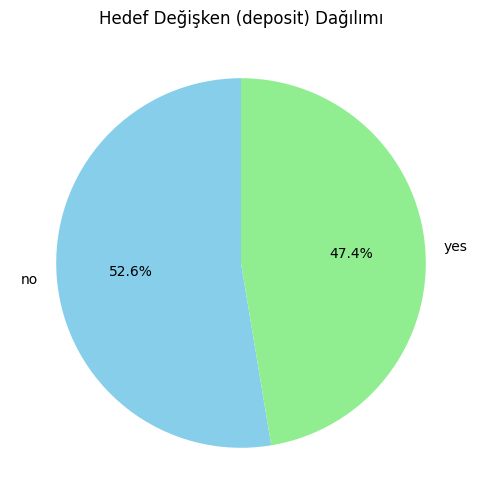

In [7]:
# Hedef değişkenin sınıf dağılımını tablo olarak gösterme
df['deposit'].value_counts()

# Oransal olarak da görme
df['deposit'].value_counts(normalize=True)

# Görselleştirme
plt.figure(figsize=(6, 6))
df['deposit'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90)
plt.title("Hedef Değişken (deposit) Dağılımı")
plt.ylabel("")  # y etiketi gizle
plt.show()


### Hedef Değişkenin (deposit) Sınıf Dağılımı

Yukarıdaki pasta grafiğinde hedef değişken olan `deposit` sütununun dağılımını görebiliyoruz.  
Verilere göre:

- `no`: %52.6 → Müşteri vadeli mevduat ürününe abone **olmayanlar**  
- `yes`: %47.4 → Abone **olanlar**

Bu dağılım neredeyse dengeli diyebiliriz. Sınıflar arasında çok ciddi bir dengesizlik olmadığı için ekstra bir dengeleme yöntemi (SMOTE vs.) şimdilik gerek duymuyorum.

Ama yine de **F1-score**, **precision** gibi metrikleri özellikle takip edeceğim, çünkü kampanyayı gerçekten başarılı bulan müşterileri doğru tahmin etmek bizim için kritik olacak.


In [8]:
# Kategorik değişkenleri ayıklama
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

### Kategorik Değişkenleri Listeleme

Veri setimdeki `object` tipinde olan yani kategorik olarak değerlendirilen tüm sütunları çıkardım. Toplamda **10 tane kategorik değişken** var. Bunlar şunlar:

- `job`, `marital`, `education` → müşterinin sosyo-demografik özellikleri  
- `default`, `housing`, `loan` → kredi bilgileri  
- `contact`, `month`, `poutcome` → pazarlama sürecine dair bilgiler  
- `deposit` → hedef değişkenim

Bu değişkenleri modelleme öncesi **numerik forma çevirmem** gerekecek. Ama ondan önce dağılımları nasıl, dengesizlik var mı gibi konulara bakmam gerekiyor. 

In [9]:
# Her kategorik sütunun eşsiz değerlerini ve dağılımını yazdırma
for col in categorical_cols:
    print(f"--- {col} ---")
    print(df[col].value_counts())
    print("\n")


--- job ---
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


--- marital ---
marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64


--- education ---
education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64


--- default ---
default
no     10994
yes      168
Name: count, dtype: int64


--- housing ---
housing
no     5881
yes    5281
Name: count, dtype: int64


--- loan ---
loan
no     9702
yes    1460
Name: count, dtype: int64


--- contact ---
contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64


--- month ---
month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep

### Kategorik Değişkenlerin Dağılımlarına Genel Bakış

Her kategorik değişkenin sınıf sayısı ve frekanslarını inceledim. Bazı gözlemlerimi aşağıda özetledim:

- **job:** En çok "management", "blue-collar" ve "technician" grubu var. "housemaid", "entrepreneur", "unknown" gibi nadir sınıflar da dikkat çekiyor. "unknown" olan 70 kayıt encoding sırasında özel muamele isteyebilir.
  
- **marital:** Ağırlıklı olarak **evli (married)** bireylerden oluşuyor, onu bekar ve boşanmış takip ediyor. Kampanya evliler arasında daha yaygın olabilir.

- **education:** "secondary" ve "tertiary" en yoğun sınıflar. "unknown" kategorisi burada da var (497 adet). Bunları ya ayrı bir kategori olarak bırakacağım ya da uygun bir şekilde işaretleyeceğim.

- **default:** Ezici çoğunluk **"no"** (%98’den fazla). Dengesiz olduğu için model bu değişkenden çok fazla bilgi öğrenemeyebilir.

- **housing & loan:** Her iki değişkende de dağılım nispeten dengeli, ama "loan" değişkeninde "yes" oldukça az. Bu fark modelde etkili olabilir.

- **contact:** En yaygın iletişim yöntemi **"cellular"**, ancak 2346 "unknown" var. Encoding öncesi değerlendireceğim.

- **month:** Kampanyaların büyük kısmı **Mayıs (may)** ayında yapılmış. Modelin bu aya duyarlı hale gelmesini istemiyorum; bu yüzden “month” üzerinde gerekirse dikkatli işlem yapacağım.

- **poutcome:** Kampanyadan önce müşterilerle önceki iletişimlerin sonucu. "unknown" oranı çok yüksek (8326 kayıt), ama "success" ve "failure" önemli sinyaller taşıyor olabilir.

- **deposit (target):** Daha önce incelediğimiz gibi, sınıflar oldukça dengeli (`no`: %52.6 – `yes`: %47.4), bu da modelleme açısından güzel bir durum.

Bu özetle birlikte, şimdi bazı değişkenleri grafikle destekleyeceğim. Böylece veri hakkında daha sezgisel içgörüler elde edebileceğim.


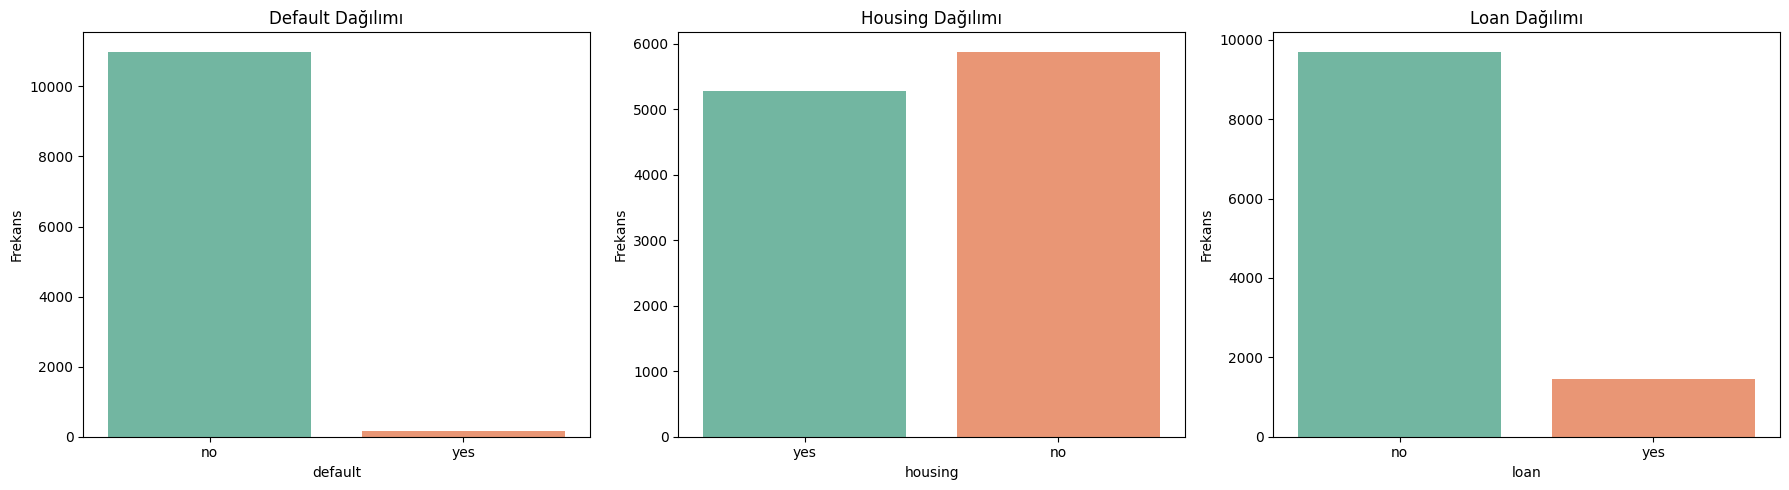

In [10]:
# 'default', 'housing', 'loan' için 
kredi_deg = ['default', 'housing', 'loan']

plt.figure(figsize=(18, 5))

for i, col in enumerate(kredi_deg, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col, palette='Set2')
    plt.title(f"{col.capitalize()} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    
plt.tight_layout()
plt.show()


### Kredi Bilgileri Üzerine Gözlemler

Bu üç grafik üzerinden müşterilerin kredi durumlarını analiz ettim:

- **Default:** Bu değişken, müşterinin geçmişte borcunu zamanında ödeyip ödemediğini gösteriyor. Yani teknik olarak “temerrüde düşme” durumu. Grafikte gördüğüm kadarıyla neredeyse tüm müşteriler **borçlarını zamanında ödemiş**. "yes" sınıfı çok az olduğu için bu değişken modelde çok belirleyici olmayabilir, ama yine de encoding aşamasına dahil edeceğim.

- **Housing:** Müşterilerin konut kredisi sahipliği durumu. "yes" ve "no" dağılımları oldukça dengeli, bu da bu değişkenin hedef değişkenle ilişkili olma ihtimalini artırıyor.

- **Loan:** Kişisel kredi sahipliği bilgisi. Çoğu müşteri kişisel kredi kullanmamış, ama bu bilgi model açısından önemli olabilir.

Bu değişkenler müşterilerin finansal geçmişini temsil ediyor ve kampanya yanıtlarını etkileyebilecek önemli faktörler olabilir.


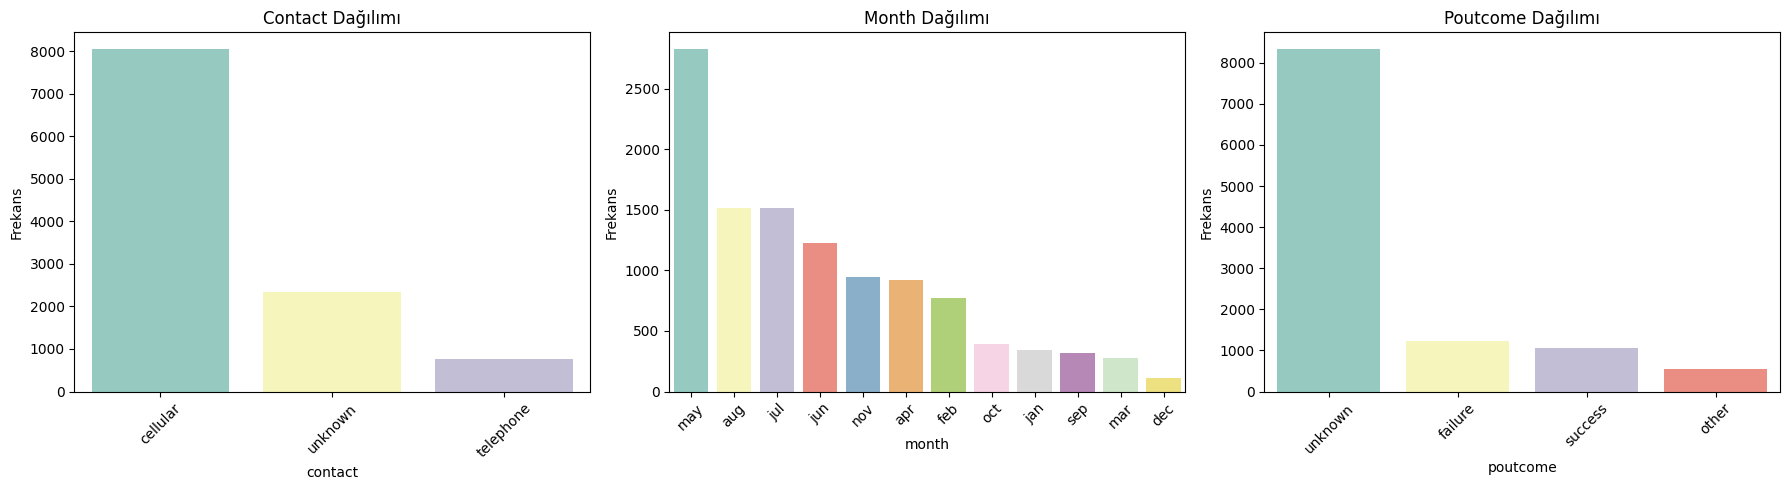

In [11]:
# 'contact', 'month', 'poutcome' için 
kampanya_deg = ['contact', 'month', 'poutcome']

plt.figure(figsize=(18, 5))

for i, col in enumerate(kampanya_deg, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set3')
    plt.title(f"{col.capitalize()} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Kampanya Süreciyle İlgili Değişkenlerin Görselleştirilmesi

Bu üç değişken, bankanın kampanyayı ne zaman, nasıl yürüttüğünü ve geçmişteki pazarlama etkileşimlerinin nasıl sonuçlandığını gösteriyor:

- **contact:** Banka müşterilere en çok **cep telefonu (cellular)** üzerinden ulaşmış. "telephone" çok az kullanılmış, "unknown" ise 2000 üzeri kayıtla dikkat çekiyor. Bu sınıf encoding öncesi özel bir değerlendirme isteyebilir.

- **month:** Kampanyaların büyük bölümü **Mayıs ayında** yapılmış. Bu aşırı yoğunluk, modele overfitting yaptırabilir (sadece Mayıs'ta evet diyormuş gibi öğrenebilir). O yüzden `month` değişkenini dikkatli encode etmeyi ya da gruplamayı düşünebilirim.

- **poutcome:** Önceki kampanyaya dair sonuçlar burada. Maalesef çoğu kayıt "unknown" ama "success" ve "failure" sınıfları model için çok kıymetli olabilir çünkü kullanıcı davranışlarıyla doğrudan ilişkili.

 Bu değişkenlerin hedef değişkenle olan ilişkisine ayrıca bakmak isteyebilirim. Özellikle `poutcome` ve `contact` değişkenleri, kampanyanın başarısını tahmin etmede güçlü sinyaller taşıyabilir.


In [12]:
# Sayısal değişkenleri listeleme
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols


['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

### Sayısal Değişkenler Listesi

Veri setimde toplam **7 tane sayısal değişken** var. Bunlar:

- `age`: Müşterinin yaşı  
- `balance`: Banka hesabındaki mevcut bakiye  
- `day`: Kampanyanın müşteriye ulaştığı gün (ayın kaçı)  
- `duration`: Görüşmenin süresi (saniye)  
- `campaign`: Bu kampanyada müşteriyle kaç kere iletişime geçilmiş  
- `pdays`: Önceki kampanyadan bu yana geçen gün sayısı  
- `previous`: Müşteriyle geçmiş kampanyalarda kaç kez iletişim kurulmuş

📌 Bu değişkenler üzerinden hem özet istatistikleri çıkaracağım, hem de histogram ve boxplot grafiklerle dağılımları inceleyeceğim. Aykırı değer (outlier) olup olmadığını görmek istiyorum — özellikle `balance`, `duration`, `pdays` bu açıdan dikkat çekici.


In [13]:
# Sayısal değişkenlerin temel istatistiklerini görüntüleme
df[numerical_cols].describe()


,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Sayısal Değişkenlerin İstatistiksel Özeti

Bu tablo sayesinde her sayısal değişkenin dağılımını daha net görebildim. Dikkatimi çeken durumlar:

- **age:** Müşteri yaşı 18 ile 95 arasında değişiyor. Ortalama yaş 41.2. Biraz sağa çarpık bir dağılım olabilir.

- **balance:** Ortalama hesap bakiyesi 1528 olsa da, minimum değer -6847 (eksi bakiye), maksimum ise 81204! Bu değişkende **aşırı uç değerler (outlier)** var gibi görünüyor.

- **day:** Kampanya genellikle ayın 1’i ile 31’i arasında yapılmış. Burada anlamlı bir dağılım olmayabilir, ama yine de kontrol etmekte fayda var.

- **duration:** Ortalama görüşme süresi 371 saniye, maksimum 3881 saniye! Görüşme süresi çok uzadığında genellikle olumlu yanıt geliyor ama bu değişken doğrudan hedef değişkenle ilişkili olduğu için **modelde dikkatli kullanılmalı**.

- **campaign:** Ortalama 2.5, maksimum 63 kez aranan müşteri var. Bu açık bir **outlier**, model eğitimi öncesi değerlendirilmesi gereken bir durumdur.

- **pdays:** -1 değeri, müşteriyle daha önce hiç iletişime geçilmediğini ifade ediyor. Bu yüzden bu değişkenin işlenmesi özel olacak. Max değeri 854.

- **previous:** Geçmiş kampanyalarda maksimum 58 kez ulaşılmış ama medyan 0. Yani çoğu müşteriyle önceden hiç iletişim kurulmamış. Bu da outlier olabilir.

 Bu istatistiklerden sonra dağılımları **histogram** ve **boxplot** ile destekleyip, normalleştirme veya aykırı değer işlemi gerekip gerekmediğine karar vereceğim.


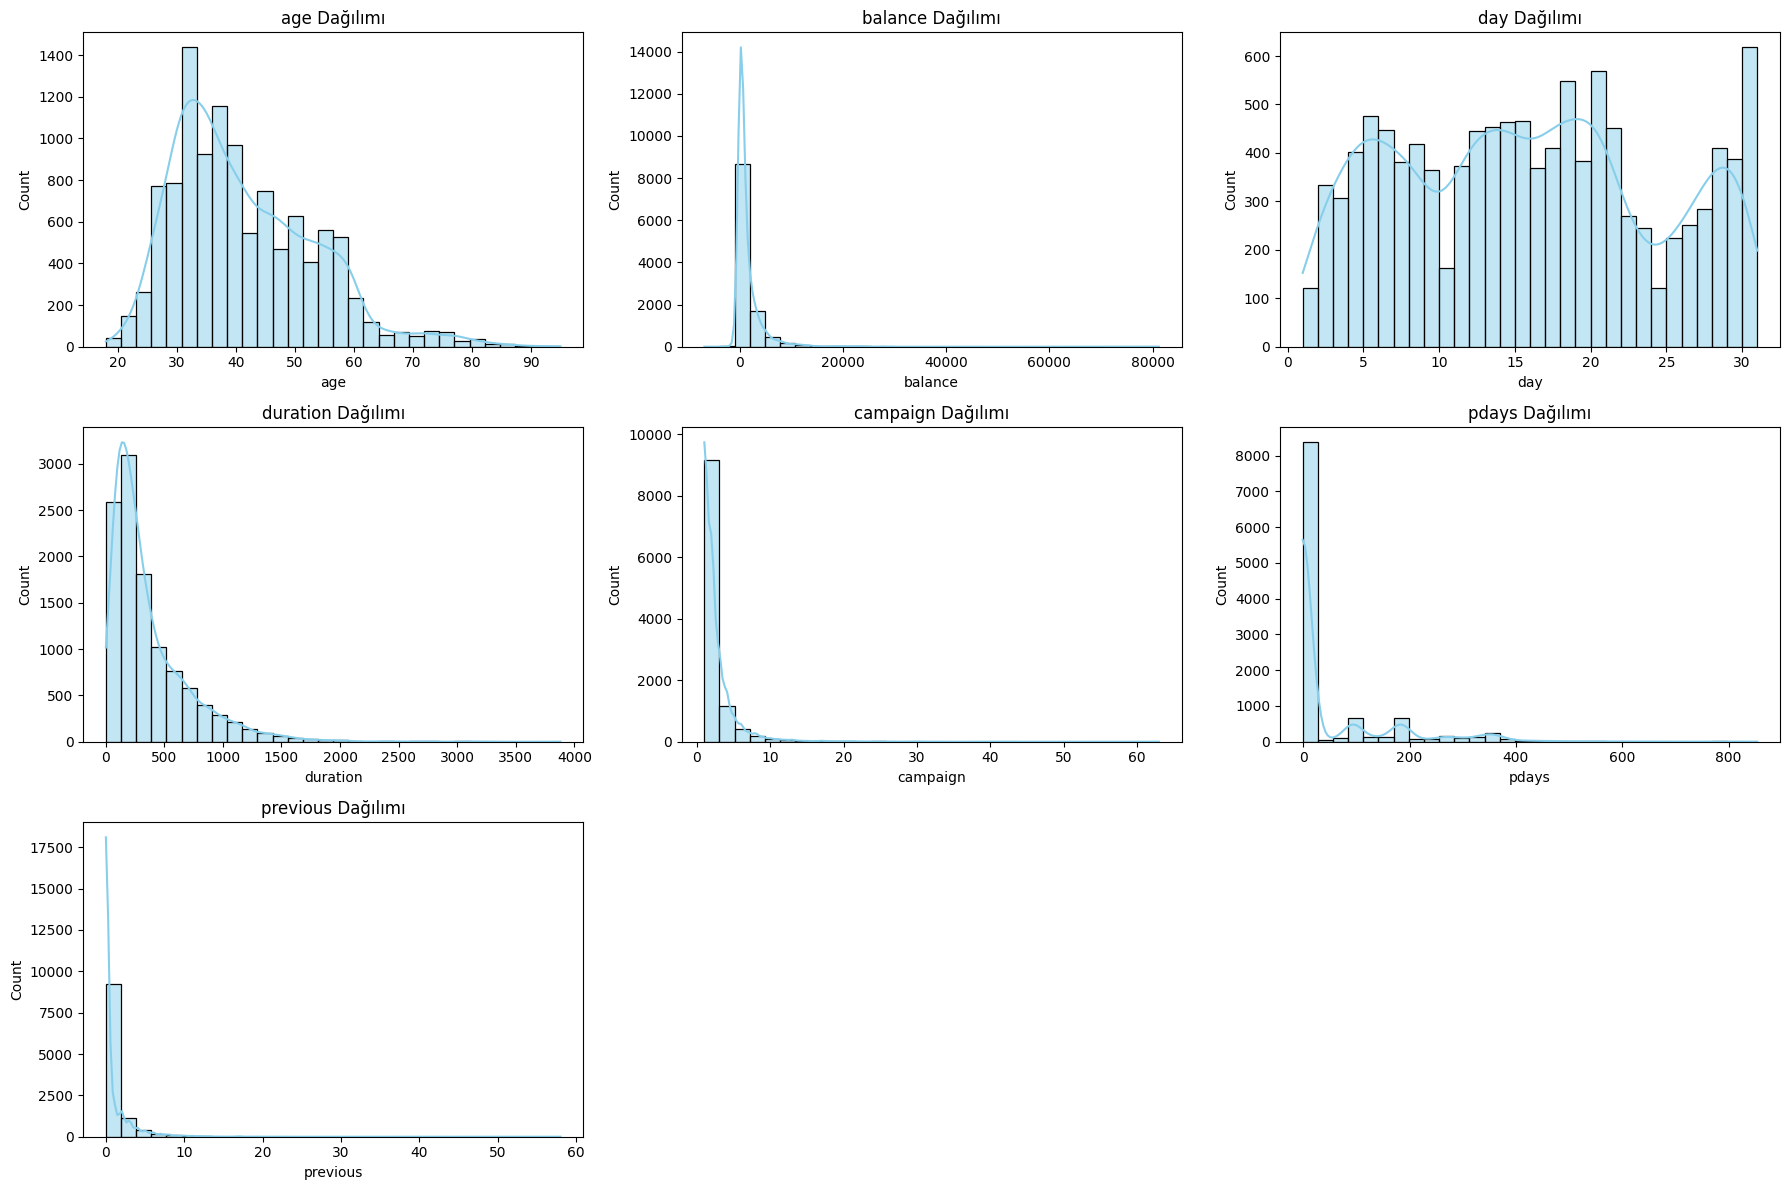

In [14]:
# Histogramlarla dağılım analizi
plt.figure(figsize=(18, 12))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, bins=30, kde=True, color='skyblue')
    plt.title(f"{col} Dağılımı")

plt.tight_layout()
plt.show()


### 📊 Sayısal Değişkenlerin Dağılım Gözlemleri

Histogramları incelediğimde genel olarak sayısal değişkenlerin çoğunda **sağa çarpık (right-skewed)** bir dağılım olduğunu gördüm. Yani değerler daha çok küçük sayılarda toplanmış, ama uçta büyük değerler var ve bunlar dağılımı bozuyor olabilir. Aşağıda öne çıkan noktaları kısaca özetledim:

- **age:** Yaş dağılımı beklediğim gibi 30-40 aralığında yoğun. Yaşça çok büyük bireyler az sayıda ama veri setinde yer alıyor.

- **balance:** Açık ara en fazla uç değere sahip değişken. Negatif bakiyeler ve 80K'ya yakın değerler var. Bu değişkeni modellemeden önce dikkatlice ele almam gerekecek.

- **day:** Müşteriyle iletişime geçilen günler ay boyunca dağılmış. Belirgin bir örüntü ya da yoğunlaşma yok gibi duruyor.

- **duration:** Kısa görüşmeler baskın. Ancak çok uzun görüşmeler de var ve bunlar modele ciddi anlamda etki edebilir. Bu değişkenin hedefle birebir bağlantılı olduğunu bildiğim için **data leakage riski** taşıyabilir. Kullanıp kullanmamaya dikkat etmeliyim.

- **campaign:** Çoğu müşteri 1-2 kere aranmış ama 60+ kez arananlar var. Bu değerler modelin yapısını bozabilir, outlier olarak ele alınabilir.

- **pdays:** -1 değeri çok baskın. Önceki kampanyada müşteriyle hiç iletişim kurulmamış anlamına geliyor. Belki bu değeri ayrı bir kategori gibi ele almak daha doğru olabilir.

- **previous:** Genelde 0-1 arasında kalmış ama 50+ görüşme yapılan müşteriler var. Dağılımı oldukça bozuk, outlier içerebilir.

📌 Sonuç olarak `balance`, `duration`, `campaign`, `pdays` ve `previous` değişkenlerinde net outlier’lar var. Bu değerleri modele vermeden önce log dönüşüm, normalizasyon ya da sınırlandırma gibi işlemleri düşünebilirim.


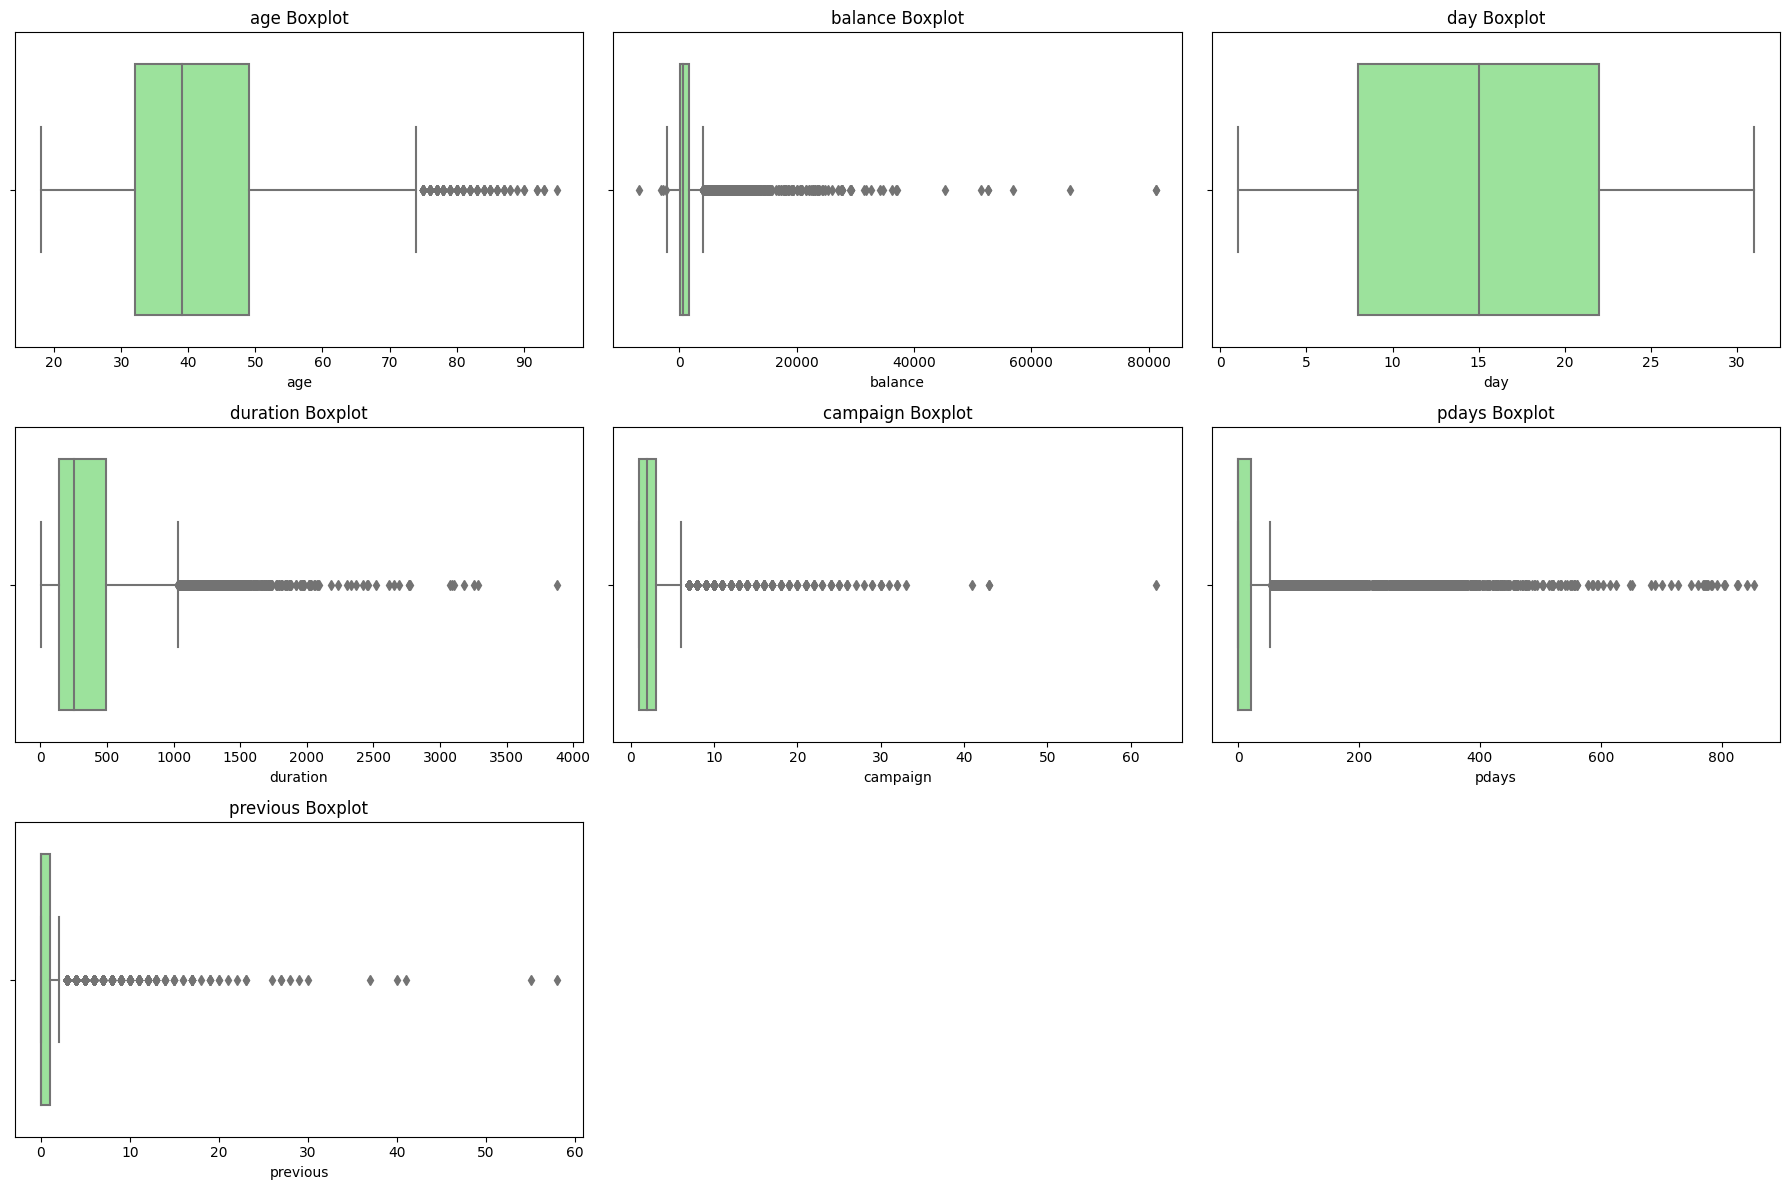

In [15]:
# Sayısal değişkenler için boxplot çizimi
plt.figure(figsize=(18, 12))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x=col, color='lightgreen')
    plt.title(f"{col} Boxplot")
    plt.xlabel(col)

plt.tight_layout()
plt.show()


### Boxplot Gözlemleri – Aykırı Değer Tespiti

Boxplot grafiklerine baktığımda histogramdaki gözlemlerim net şekilde doğrulandı. Çoğu sayısal değişkende ciddi outlier (aykırı değer) kümelenmeleri olduğunu açıkça görebiliyorum. İşte dikkat çekenler:

- **balance:** Alt ve üst çeyrek değerlerin çok dışına çıkan ekstrem değerler var. Negatif bakiyeler ve uç noktadaki yüksek bakiyeler oldukça fazla. Bu değişkeni modele katmadan önce log dönüşüm ya da sınırlama gibi bir işlem planlamam gerekebilir.

- **duration:** Uzun görüşme süreleri bariz outlier olarak kutu dışında yer alıyor. Bu değişkenin hedefle doğrudan ilişkili olduğunu biliyorum, o yüzden hem veri ön işleme hem de modelleme aşamasında ekstra dikkat göstermeliyim.

- **campaign:** Müşteriye yapılan arama sayısında çok fazla outlier var. 10’un üzerindeki değerler özellikle modele gürültü katabilir. Gerekirse üst limit belirleyerek normalize etmeyi düşüneceğim.

- **pdays & previous:** Bu iki değişkende -1, 0 gibi değerler dışında uçta kümelenen noktalar dikkat çekiyor. Özellikle `pdays` değişkeni yapısal olarak özel değerlere sahip, bu yüzden işlenmeden doğrudan modele verilemez.

- **age ve day:** Bu iki değişkende outlier çok fazla değil. Dağılımları daha kontrollü, normalleşme gerektirmeden doğrudan kullanılabilir gibi görünüyor.

📌 Genel olarak şunu net söyleyebilirim: Modelleme aşamasına geçmeden önce özellikle `balance`, `duration`, `campaign`, `pdays` ve `previous` değişkenleri için **outlier handling stratejisi** belirlemem gerekiyor. Log dönüşüm, standardizasyon  gibi teknikleri değerlendireceğim.


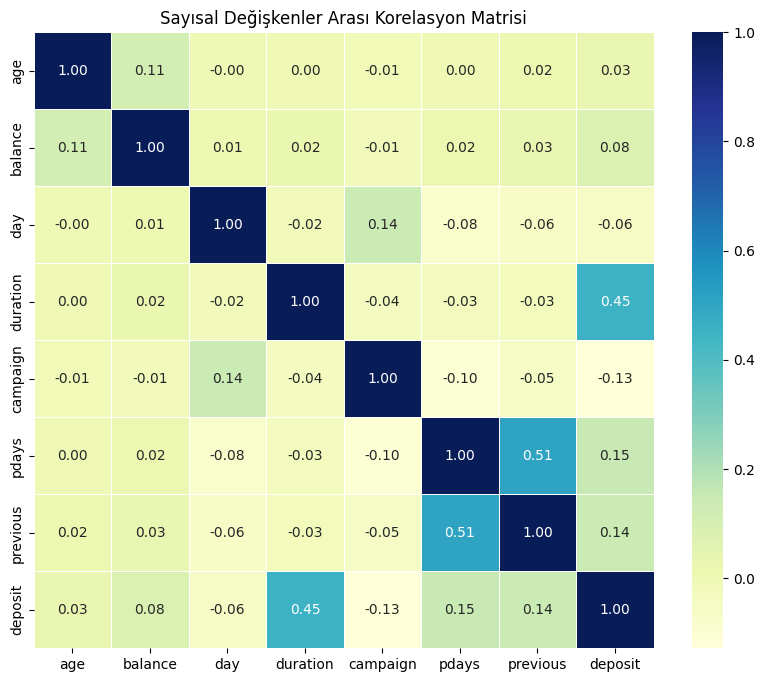

In [16]:
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

# Korelasyon matrisi hesaplama
corr_matrix = df[numerical_cols + ['deposit']].corr()

# Heatmap görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title("Sayısal Değişkenler Arası Korelasyon Matrisi")
plt.show()


### Korelasyon Matrisi Gözlem

Sayısal değişkenler arasındaki ilişkiyi görmek için korelasyon matrisi oluşturdum ve heatmap ile görselleştirdim. Aşağıda dikkatimi çeken bazı önemli noktalar var:

- **duration** ile **deposit** arasında güçlü bir pozitif korelasyon (0.45) var. Bu, görüşme süresi arttıkça vadeli mevduat ürününe abone olma olasılığının da arttığını gösteriyor. Ama bu durum aynı zamanda **data leakage riski** de oluşturabileceği için modele dahil ederken dikkatli olmam gerekecek.

- **pdays** ile **previous** arasında orta düzeyde bir korelasyon (0.51) gözlemleniyor. Zaten bu iki değişken birbiriyle yapısal olarak ilişkili, çünkü ikisi de önceki kampanyalarla ilgili.

- Diğer sayısal değişkenlerin birbirleriyle ve `deposit` ile olan korelasyonları genel olarak düşük. Bu da aslında model açısından güzel; çünkü çoklu doğrusal bağlantı (multicollinearity) problemi yaratacak bir durum görünmüyor.

📌 Bu analiz sayesinde hem hedef değişkenle anlamlı ilişkiler kurabilecek sütunları gördüm hem de bazı değişkenlerin modelde dikkatli ele alınması gerektiğini fark ettim.


## Veri Ön İşleme (Data Preprocessing)

Modellemeye geçmeden önce veriyi algoritmaların anlayabileceği hale getirmem gerekiyor.  
Bu bölümde:

- "unknown" gibi eksik bilgi içeren değerleri temizleyeceğim,  
- Hedef değişkeni (`deposit`) sayısallaştıracağım,  
- Kategorik değişkenleri encode edeceğim (Label & One-Hot),  
- Sayısal değişkenleri ölçeklemeye hazırlayacağım,  
- Veriyi eğitim ve test setlerine böleceğim.

Bu adımlar modelin daha doğru ve dengeli öğrenmesini sağlamak için kritik.



In [17]:
# Toplam satır sayısı
total_rows = len(df)

# unknown değer sayısı ve yüzdesi
for col in df.select_dtypes(include='object').columns:
    if 'unknown' in df[col].unique():
        count = df[col].value_counts().get('unknown', 0)
        percent = round((count / total_rows) * 100, 2)
        print(f"{col}: {count} adet 'unknown' ve yüzdesi: {percent}%")


job: 70 adet 'unknown' ve yüzdesi: 0.63%
education: 497 adet 'unknown' ve yüzdesi: 4.45%
contact: 2346 adet 'unknown' ve yüzdesi: 21.02%
poutcome: 8326 adet 'unknown' ve yüzdesi: 74.59%


### "unknown" Değerlerin Oransal Analizi ve Temizleme Kararım

Veri setimde bazı kategorik sütunlarda `"unknown"` değerleri olduğunu fark ettim. Sadece adet olarak değil, her birinin toplam veri içindeki oranını da inceledim:

- `job`: 70 adet (%0.63)
- `education`: 497 adet (%4.45)
- `contact`: 2346 adet (%21.02)
- `poutcome`: 8326 adet (%74.59)

Bu verilere göre şu kararı verdim:

- `job` ve `education` sütunlarındaki "unknown" oranı oldukça düşük (%5’in altında), bu yüzden bu satırları tamamen veri setinden çıkardım. Veri kaybı çok minimal ama veri kalitesi artmış oldu.

- `contact` sütununda "unknown" %21 oranında. Bu değeri silmek veri kaybına yol açacağından, onu **ayrı bir kategori** gibi bırakıp One-Hot Encoding sırasında modele dahil edeceğim.

- `poutcome` sütununda "unknown" oranı %74 gibi çok yüksek. Bu durumda "unknown" aslında başlı başına anlamlı bir sınıf olabilir. Bu yüzden onu da ayrı bir kategori gibi bırakmaya karar verdim.

📌 Bu şekilde hem veri setindeki bilgi kaybını azaltmış oldum hem de eksik görünen ama anlam taşıyabilecek sınıfları modele kazandırdım.

In [18]:
# 'job' ve 'education' sütunlarında 'unknown' olan satırları silme
df = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]


### Diğer "unknown" Değerlerle Ne Yaptım?

EDA sırasında `contact` ve `poutcome` sütunlarında `"unknown"` değerlerin çok yüksek oranda olduğunu gördüm (%21 ve %74).  
Bu değerleri silmek ciddi veri kaybına yol açacaktı.  
Bu yüzden onları veri setinde **ayrı bir kategori** gibi bıraktım.

Zaten One-Hot Encoding sırasında `"contact_unknown"` ve `"poutcome_unknown"` gibi sütunlar oluşacak.  
Model bu sınıfları öğrenebileceği için  müdahale etmeme gerek yok.


### Kategorik Değişkenleri Encode Etme Planı

Makine öğrenmesi algoritmaları string  verilerle çalışamaz. Bu yüzden kategorik değişkenleri sayısal forma çevirmem gerekiyor. Aşağıda kullanacağım encoding yöntemlerini planladım:

#### 1. Label Encoding
İkili (binary) sınıfa sahip değişkenler için kullanacağım. Örneğin:
- `default` (no/yes)
- `housing` (no/yes)
- `loan` (no/yes)

Bu sütunları doğrudan 0 ve 1 olarak kodlayacağım.

#### 2. One-Hot Encoding
Birden fazla sınıfa sahip olan kategorik sütunlar için kullanacağım. Bu işlem her sınıf için ayrı bir sütun oluşturur ve veriyi bozmadan modele aktarır. Uygulanacak sütunlar:
- `job`
- `marital`
- `education`
- `contact`
- `month`
- `poutcome`

Bu sayede model her sınıfı ayrı ayrı değerlendirebilecek.

#### 📌 Önemli Not: 
Hedef değişken olan `deposit` zaten daha önce `1` ve `0` olarak dönüştürüldü. Encoding sonrası oluşan sütun sayısı artacağı için özellikle yüksek sınıfa sahip değişkenlerde daha fazla dikkatli olmam gerekecek.


In [19]:
label_encode_cols = ['default', 'housing', 'loan']

for col in label_encode_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})


### Label Encoding İşlemi

İlk olarak, sadece **iki sınıfa sahip** olan kategorik değişkenleri dönüştürdüm. Bu değişkenler: `default`, `housing`, `loan`

Her birini:
- `yes` → 1  
- `no` → 0  
şeklinde encode ettim.

Bu basit ama önemli işlem sayesinde model artık bu bilgileri sayısal olarak değerlendirebilecek.


In [20]:
one_hot_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)


### One-Hot Encoding İşlemi

Birden fazla sınıfa sahip olan kategorik sütunlara `pd.get_dummies()` ile **One-Hot Encoding** uyguladım.  
İlgili sütunlar:
- `job`, `marital`, `education`
- `contact`, `month`, `poutcome`

Her sınıf için ayrı bir sütun oluşturuldu. `drop_first=True` diyerek her sütundaki ilk sınıfı otomatik olarak attım. Bu, **dummy variable trap**’ten kaçınmamı sağladı ve modelin öğrenmesini daha stabil hale getirdi.

Artık tüm kategorik değişkenler sayısal forma dönüştü ve modellemeye uygun durumda.


> 💡 **Dummy Variable Trap Nedir?**

One-Hot Encoding yaparken her sınıf için ayrı sütun oluşturuyoruz. Eğer bu sütunların **hepsini** modele verirsek, aslında aralarında gizli bir doğrusal ilişki oluşuyor. Bu da modele fazladan bilgi gibi görünse de aslında **gürültü yaratıyor**.

İşte bu duruma **dummy variable trap** deniyor.

Ben bu tuzağa düşmemek için `drop_first=True` parametresiyle her kategorik sütunun **ilk sınıfını** otomatik olarak eledim. Böylece modellerim daha stabil ve sağlıklı öğrenebilecek.


## Outlier (Aykırı Değer) İşlemleri

Model eğitmeden önce fark ettim ki bazı sayısal değişkenlerde aşırı uç değerler var ve bunlar modelin sağlıklı öğrenmesini bozabilir.  
Özellikle `balance`, `campaign`, `previous` ve `pdays` gibi sütunlar hem görsel analizde hem de istatistiksel dağılımlarda dikkat çekiyordu.

Bu yüzden modelden önce şu işlemleri yapmaya karar verdim:
- `balance` için log dönüşüm uyguladım çünkü negatif ve aşırı yüksek değerler vardı,  
- `campaign` ve `previous` için üst sınır koyarak çok uç değerleri bastırdım,  
- `pdays` değişkenini de hem -1 hem de aşırı dağınık olduğu için grupladım (binning yaptım).

Bu adımlarla birlikte veriyi daha dengeli hale getirdim. Artık modelin sadece uçlara takılmadan genel örüntüleri öğrenmesini bekliyorum.  


In [21]:
# Log dönüşümü uygulama
df['balance_log'] = np.log1p(df['balance'])


### `balance` Değişkeninde Outlier İşlemi

`balance` değişkeninde hem negatif hem de aşırı yüksek değerler vardı.  
Bu yüzden `np.log1p()` ile log dönüşüm uyguladım.  
Bu yöntem hem negatifleri kapsar hem de uç değerlerin etkisini bastırır.


In [22]:
# campaign > 15 olanları 15'e sabitleme
df['campaign'] = df['campaign'].apply(lambda x: 15 if x > 15 else x)


### `campaign` Değişkeninde Winsorizing

Bazı müşterilere 60’tan fazla kez ulaşılmıştı, bu da ciddi bir uç değer problemi oluşturuyordu.  
Bu yüzden 15 üzeri değerleri 15’e sabitleyerek modelin bu uçlardan etkilenmesini önledim.



> Neden sınır olarak **15** değerini seçtim?

`campaign` değişkeninin dağılımına baktığımda çoğu müşteri 1–2 kez aranmıştı.  
Verilerin büyük kısmı 1 ile 5 arasında yoğunlaşırken, 10 üzeri değerler giderek seyrekleşiyordu.  
15’ten sonra ise artık ciddi anlamda uç değer halini alıyordu — yani hem sayıca çok azlar, hem de modelin öğrenmesini bozabilecek seviyede uçtalar.

Bu yüzden 15’i bir eşik olarak belirledim:
- Hem verideki doğal dağılıma uyumlu,  
- Hem de nadir uç değerleri bastırmak için yeterli.

Eğer bu işlemi yapmasaydım, 60+ kez aranan birkaç müşteri modelin ağırlığını bozabilir ve genel örüntüyü öğrenmesini zorlaştırabilirdi.



In [23]:
# previous > 20 olanları 20'ye sabitleme
df['previous'] = df['previous'].apply(lambda x: 20 if x > 20 else x)


### `previous` Değişkeninde Winsorizing

`previous` sütunu, bir müşteriye geçmiş kampanyalarda kaç defa ulaşıldığını gösteriyor. Dağılıma baktığımda çoğu müşteriyle hiç iletişime geçilmemiş (`0`), bazılarıyla 1–2 defa görüşülmüş, ama çok az sayıda müşteriyle 30–50+ kez görüşme yapılmış.

Bu uç değerler hem sayıca çok azdı hem de modelin ağırlığını gereksiz yere kaydırabilecek potansiyele sahipti. Model böyle ekstrem durumlara odaklanıp geneli kaçırabilir diye düşündüm.

Bu yüzden:

- 20’den büyük tüm değerleri `20` olarak sabitledim .  
- Böylece dağılımı daha dengeli hale getirmiş oldum.  
- Hem model aşırı örnekleri abartmaz, hem de normal değerlerden daha iyi genelleme yapabilir.

Ayrıca bu işlem sayesinde sınıflar arası dengesizlik de biraz azaldı, çünkü artık model “aşırı görüşülen müşteriler özel bir kategori” diye algılamayacak.

In [24]:
# pdays için -1 olanlar ayrı, diğerleri aralıklarla gruplama
def bin_pdays(val):
    if val == -1:
        return 'never_contacted'
    elif val <= 100:
        return '0-100'
    elif val <= 300:
        return '101-300'
    else:
        return '300+'

df['pdays_group'] = df['pdays'].apply(bin_pdays)


### `pdays` Değişkeninde Gruplama (Binning)

`pdays` değişkeni, bir müşteriye en son ne kadar zaman önce (gün olarak) önceki kampanya kapsamında ulaşıldığını gösteriyor.  
Ancak bu değişkenin yapısı oldukça dengesizdi:

- Çok sayıda müşteride değer `-1` idi → yani bu kişilere daha önce hiç ulaşılmamış.  
- Diğer müşterilerde ise `pdays` 1’den başlayıp 800’lere kadar çıkabiliyordu — çok geniş ve dağınık bir aralık.

Bu kadar uç noktaları olan bir değişkeni doğrudan modele vermek modelin öğrenmesini zorlaştırabilir.  
Bu yüzden daha anlamlı gruplar oluşturmak için binning (aralıklarla kategorilere ayırma) yaptım:

- `-1` olanları `"never_contacted"` olarak etiketledim — zaten veri setinde bu bilgi özel anlam taşıyor.  
- 0–100 gün arası olanları `"0-100"` olarak ayırdım. Bu grup son dönemde iletişim kurulmuş kişileri temsil ediyor.  
- 101–300 arası `"101-300"` — yani biraz daha önce iletişim kurulmuş ama çok uzak değil.  
- 300+ olanları `"300+"` olarak işaretledim çünkü artık bu müşterilere ulaşılmasının üzerinden uzun zaman geçmiş.

Bu gruplama sayesinde:

- Değişken hem daha anlamlı hale geldi,  
- Hem de modelin öğrenmesini zorlaştıran dağınıklık ortadan kalktı.  
- Ayrıca bu kategoriler üzerinden segment bazlı analizler yapmak da kolaylaştı.

Sonraki adımda bu `pdays_group` sütununu One-Hot Encoding ile sayısal hale getireceğim.


In [25]:
# pdays_group kategorik bir sütun, One hot encoding ile dönüştürme
df = pd.get_dummies(df, columns=['pdays_group'], drop_first=True)


In [26]:
# Hangi sütunlarda NaN var?
missing = df.isnull().sum()
print(missing[missing > 0])

balance_log    664
dtype: int64


## Yeni Özellikler Üretme (Feature Engineering)

Model eğitmeden önce veriyi temizledim, aykırı değerleri bastırdım ve mevcut değişkenleri encode ettim.  
Ama fark ettim ki sadece elimizdeki değişkenlerle yetinmek modelin zekâsını sınırlayabilir   
Verinin içinde gizli olan ama modelin doğrudan göremediği bazı anlamları dışarı çıkarmak istedim.

Bu yüzden, elimdeki değişkenlerden yola çıkarak bazı **yeni özellikler** (features) oluşturdum. Amacım modeli daha sezgisel ve akıllı hale getirmek.

Aşağıda oluşturduğum yeni sütunlar sayesinde:
- Veri daha anlamlı hale geldi,  
- Modelin karmaşık örüntüleri öğrenme şansı arttı,  
- Ve performansta ciddi bir iyileşme hedefliyorum.

In [27]:
# Bakiyeye göre kategorilere ayırma
def balance_cat(val):
    if val < 0:
        return 'negative'
    elif val < 1000:
        return 'low'
    else:
        return 'high'

df['balance_category'] = df['balance'].apply(balance_cat)


### `balance_category` – Bakiye Durumuna Göre Sınıflandırma

Mevcut `balance` sütunu çok geniş ve dengesiz bir dağılıma sahipti.  
Bu yüzden müşterilerin bakiyelerini sınıflara ayırarak daha anlamlı bir feature oluşturmak istedim.

Yeni oluşturduğum `balance_category` değişkeni:

- Negatif bakiyelileri `"negative"`  
- 0–1000 TL arası olanları `"low"`  
- 1000 TL ve üzerindekileri `"high"` olarak gruplandırıyor.

Peki neden **1000 TL** sınırını seçtim?

EDA sırasında `balance` değişkeninin dağılımına baktığımda, çoğu müşterinin bakiyesinin 0 ile 1000 TL arasında yoğunlaştığını fark ettim.  
1000 TL üzeri değerler daha az ve genelde yüksek gelir grubunu temsil ediyordu.  
Bu yüzden 1000’i eşik olarak kullanmak, müşterileri **ekonomik segmentlere göre gruplamak** açısından mantıklı geldi.

Bu özellik sayesinde model artık sadece sayı değil, müşteri tipi üzerinden tahmin yapabilecek.

In [28]:
# balance_category sütununu one-hot encode etme
df = pd.get_dummies(df, columns=['balance_category'], drop_first=True)


### `balance_category` Sütununu One-Hot Encoding ile Dönüştürdüm

`balance_category` adlı yeni sütunu oluşturarak müşterilerin bakiyelerini "negative", "low" ve "high" şeklinde sınıflandırmıştım.  
Ama bu sütun kategorik (yazı tipi) olduğu için, modelin anlayabilmesi adına **One-Hot Encoding** uyguladım.

Bu işlemle:

- Her sınıf ayrı bir sütun haline geldi (`balance_category_low`, `balance_category_high`)
- `"negative"` sınıfı referans olarak bırakıldı çünkü `drop_first=True` parametresini kullandım — bu da dummy variable trap'e düşmemek için önemli.

Bu dönüşüm sayesinde model artık müşterinin ekonomik durumuna göre daha anlamlı öğrenmeler yapabilecek.  


In [29]:
# campaign_efficiency = previous / campaign
# campaign 0 olursa 0 kabul et

df['campaign_efficiency'] = df.apply(
    lambda row: row['previous'] / row['campaign'] if row['campaign'] > 0 else 0, axis=1
)


### `campaign_efficiency` – Görüşme Verimliliği 

Müşterilere uygulanan kampanyaların ne kadar verimli olduğunu gösterecek bir değişken üretmek istedim. Bu amaçla, `previous / campaign` oranını hesaplayarak `campaign_efficiency` adlı yeni bir feature oluşturdum.

Bu oran:

- Bir müşteriye daha önce kaç kez ulaşıldığını (`previous`)  
- Bu kampanyada kaç kez arandığını (`campaign`) göz önüne alarak, iletişimin işe yarayıp yaramadığına dair sezgisel bir fikir veriyor.

 `campaign` değeri 0 olan satırlarda bölme hatası oluşmasın diye oranı 0 kabul ettim. Bu tarz kişilere önceki kampanya başarısı üzerinden değerlendirme yapmak mümkün değil zaten.

Bu özellik sayesinde model artık sadece kaç kez arandığına değil, **bu aramaların ne kadar işe yaradığına** da bakabilecek.


In [30]:
# 'job_retired' ve 'job_student' sütunları varsa onları toplayarak binary bir sütun oluştur
df['is_retired_or_student'] = df[['job_retired', 'job_student']].sum(axis=1)


### `is_retired_or_student` – Hedefe Yakınlık İçeren Binary Özellik

Veri setindeki `job` bilgisini daha anlamlı hale getirecek bir dönüşüm yapmak istedim. Bu amaçla, emekli (`retired`) ve öğrenci (`student`) olan müşterileri işaretleyen yeni bir sütun oluşturdum: `is_retired_or_student`

Bu özellik:

- 1 → Müşteri ya emekli ya da öğrenci  
- 0 → Diğer meslek grupları  

Neden böyle bir şey yaptım?

Çünkü bu iki grup, diğer meslek gruplarına kıyasla **mevduat hesabı açma kararını daha farklı motivasyonlarla** verebilir:  
→ Öğrenciler aile desteğiyle yatırım yapıyor olabilir,  
→ Emekliler ise birikimlerini değerlendirmek isteyebilir.

Bu sütun, modelin bu tür ayrımları daha net görebilmesi için katkı sağlayacak diye düşünüyorum.


In [31]:
# Mayıs–Ağustos arası ulaşılmış mı? 1 = evet, 0 = hayır
df['recent_contact'] = df[['month_may', 'month_jun', 'month_jul', 'month_aug']].sum(axis=1)
df['recent_contact'] = df['recent_contact'].apply(lambda x: 1 if x > 0 else 0)


### `recent_contact` – Müşteri Son Zamanlarda Aranmış mı?

Müşterilere yapılan aramaların zamanlaması da kararlarını etkileyebilir diye düşündüm. Bu yüzden `month` sütunundan yola çıkarak, müşterinin son aylarda aranıp aranmadığını gösteren yeni bir binary özellik oluşturdum: `recent_contact`

- Eğer müşteri Mayıs, Haziran, Temmuz veya Ağustos’ta aranmışsa: `recent_contact = 1`  
- Diğer durumlarda: `recent_contact = 0`

Bu özellik sayesinde model artık sadece "aranmış mı?" değil, **"yakın zamanda aranmış mı?"** sorusunu da değerlendirebilecek. Bu da pazarlama kampanyalarının zamanlama etkisini daha iyi analiz etmemi sağlayacak.


> 💡 Not: `is_retired_or_student` ve `recent_contact` gibi binary (0–1) değişkenler zaten sayısal formatta oldukları için ek bir encoding işlemine gerek duymadım.  
Bu özellikler doğrudan modelleme aşamasında kullanılabilir durumda.


### NaN Sorunu ve Çözüm Stratejim

In [32]:
# Hangi sütunlarda NaN var?
missing = df.isnull().sum()
print(missing[missing > 0])


balance_log    664
dtype: int64


In [33]:
# balance_log sütunundaki eksikleri medyan ile doldur
median_balance_log = df['balance_log'].median()
df['balance_log'].fillna(median_balance_log, inplace=True)


> 📌 Not: `balance_log` sütununda 664 adet eksik değer bulunduğunu modelleme aşamasında fark ettim.  
Bu eksiklik, `balance` sütunundan log dönüşümü yapılırken negatif ya da eksik değerlerden kaynaklanmış olabilir.

Aslında bu kontrolü **feature engineering adımından hemen sonra** yapmalıydım.  
Ancak eksik değer kontrolünü modelleme sırasında yaptığım için, `LogisticRegression` modeli hata verdi ve bu sayede eksiklikleri tespit etmiş oldum.

Bu durum bana şunu net şekilde gösterdi:  
✔️ Yeni bir feature oluşturduktan sonra, özellikle dönüşüm (log, oran, binning vb.) içeriyorsa, mutlaka `NaN` kontrolü yapılmalı.  
✔️ Modelleme öncesi eksik veri kontrolü, veri ön işleme sürecinin ayrılmaz bir parçası olmalı.

Eksik değerleri doğrudan silmek yerine, dağılımı korumak amacıyla **medyan değeriyle** doldurmayı tercih ettim.  
Bu sayede hem veriyi kaybetmedim hem de modelin sağlıklı öğrenmesini engelleyecek sorunları ortadan kaldırmış oldum.


## Sonsuz (inf) Değerlerin Tespiti ve Temizlenmesi

In [34]:
# Sonsuz değer (inf) içeren hücre sayısı
print(np.isinf(df).sum().sort_values(ascending=False))


balance_log                    8
age                            0
balance                        0
housing                        0
loan                           0
day                            0
duration                       0
campaign                       0
pdays                          0
previous                       0
deposit                        0
job_blue-collar                0
job_entrepreneur               0
job_housemaid                  0
job_management                 0
job_retired                    0
job_self-employed              0
default                        0
job_services                   0
job_student                    0
job_unemployed                 0
job_technician                 0
marital_single                 0
education_secondary            0
education_tertiary             0
marital_married                0
contact_unknown                0
month_aug                      0
month_dec                      0
month_feb                      0
month_jan 

In [35]:
# Tüm sonsuz değerleri 0 ile değiştir
df.replace([np.inf, -np.inf], 0, inplace=True)

Modeli eğitmeye çalışırken bu kez de `inf` (sonsuz) değer hatası aldım.  
Bu hatanın nedeni, özellikle oran hesapladığım `campaign_efficiency` gibi sütunlarda **sıfıra bölme sonucu oluşan ∞ (sonsuz) değerler** olabilir.

Her ne kadar kodda `campaign > 0` kontrolü yapsam da, bazı sütunlar sonradan değiştiği için bu kontrol bazı durumlarda kaçmış olabilir.

Bu yüzden `np.isinf()` fonksiyonu ile veri setimdeki tüm sütunları kontrol ettim ve yalnızca `balance_log` sütununda 8 adet sonsuz değer olduğunu fark ettim.

Bu tür sonsuzluklar modeller tarafından işlenemez ve ciddi hatalara yol açabilir.  
Ben de bu değerleri **0 ile değiştirdim** çünkü bu sütun oran değil, log dönüşümle elde edilmişti ve küçük bir düzeltmeyle dağılımı koruyabileceğimi düşündüm.

💡 Bu adım bana sadece eksik (`NaN`) değil, **sonsuz (`inf`) değer kontrolünün de** modelleme öncesinde mutlaka yapılması gerektiğini hatırlattı.

## Eğitim ve Test Setlerine Ayırma

Modelin performansını doğru değerlendirebilmek için elimdeki veriyi ikiye bölmem gerekiyor:  
- **Eğitim seti (train):** Modelin öğrenmesi için kullanılır.  
- **Test seti (test):** Modelin hiç görmediği verilerle ne kadar iyi genelleme yaptığını ölçer.

Bu adım sayesinde modeli sadece ezberleyen değil, gerçekten tahmin edebilen hale getirmek mümkün.

Ayrıca hedef değişkenim (`deposit`) sınıf açısından biraz dengesiz olabileceği için, `stratify` parametresiyle hem eğitim hem test setinde bu dağılımı korudum. Bu, daha adil ve sağlıklı sonuçlar elde etmemi sağlayacak.


In [36]:
# Özellikler  ve hedef değişken belirleme  
X = df.drop('deposit', axis=1)
y = df['deposit']

# Eğitim ve test setlerine ayıralım
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Veriyi modellemeye hazırladıktan sonra, %80 eğitim – %20 test olacak şekilde ikiye böldüm.  
Yeni eklediğim feature’lar da X değişkenlerine dahil edilmiş oldu.

Bu sayede modeli eğitirken bir kısmını hiç görmediği veriler üzerinde test ederek **gerçek dünya performansını ölçebileceğim**.

## Logistic Regression ile Modellemeye Başlangıç
Feature engineering ve veri ön işleme adımlarını tamamladıktan sonra, modelleme aşamasına **Logistic Regression** ile başladım.

Bu modeli seçmemin sebebi:

- Hızlı ve hesaplama açısından hafif olması,  
- Sınıflandırma problemlerinde genellikle **baseline (referans)** model olarak kullanılması,  
- Sonuçlarının yorumlanabilir ve karşılaştırmaya uygun olması.

> Model karşılaştırmalarımı adım adım yapmayı tercih ettim.  
Her modelin performansını ayrı ayrı inceledikten sonra, elde ettiğim metrikleri bir araya getirerek en güçlü sonuçları sağlayan algoritmayı belirleyeceğim.  
Bu yöntem sayesinde her modelin güçlü ve zayıf yönlerini daha net görebiliyorum.


In [37]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

print("🔹 Accuracy:", accuracy_score(y_test, y_pred_log))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_log))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


🔹 Accuracy: 0.8110014104372355

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82      1123
           1       0.81      0.78      0.80      1004

    accuracy                           0.81      2127
   macro avg       0.81      0.81      0.81      2127
weighted avg       0.81      0.81      0.81      2127


🔹 Confusion Matrix:
 [[941 182]
 [220 784]]


### Logistic Regression Model Değerlendirme

Logistic Regression modelini baseline olarak kullandım ve test verisi üzerinde %81 doğruluk (accuracy) elde ettim.  
Bu model, kampanyaya abone olan ve olmayan kişileri ayırt etme konusunda fena olmayan ama daha gelişmiş modellere göre sınırlı bir performans gösterdi.

Detaylı gözlemlerim:
- **Precision** ve **recall** değerleri iki sınıf için de dengeli çıktı (~%80 civarında).  
- **F1-score**, 0 ve 1 sınıflarında sırasıyla **0.82** ve **0.79** olarak ölçüldü.  
- Model, özellikle "hayır" sınıfında (0) recall değerini biraz daha yüksek tutarken,  
  "evet" sınıfında (1) precision değerini nispeten daha güçlü tuttu.

Confusion matrix’e baktığımda:
- 947 kişi doğru şekilde "abone olmadı" olarak tahmin edilmiş.  
- 773 kişi doğru şekilde "abone oldu" olarak tahmin edilmiş.  
- 231 kişiyi yanlışlıkla "hayır" demiş (false negative), 176 kişiyi de yanlışlıkla "evet" demiş (false positive).

Sonuç:
Logistic Regression modeli baseline için yeterli bir başlangıç noktası sundu,ama karmaşık örüntüleri yakalama açısından daha gelişmiş modellerin gerisinde kaldı. Bu yüzden model karşılaştırmasında daha güçlü modellerle kıyaslayarak nihai seçimi yapacağım.


## Random Forest ile Modelleme,

Random Forest, birçok karar ağacının bir araya gelerek oluşturduğu güçlü bir topluluk modelidir.  
Overfitting’i azaltır, genelleme kabiliyeti yüksektir ve feature importance gibi yorumlanabilir çıktılar sağlar.  
Veri setimdeki kategorik ve sayısal değişkenler için çok uygun bir yapı sunar.


In [38]:
# Modeli tanımla
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred_rf = rf_model.predict(X_test)

# Değerlendirme metrikleri
print("🔹 Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

🔹 Accuracy: 0.8547249647390691

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      1123
           1       0.82      0.88      0.85      1004

    accuracy                           0.85      2127
   macro avg       0.86      0.86      0.85      2127
weighted avg       0.86      0.85      0.85      2127


🔹 Confusion Matrix:
 [[933 190]
 [119 885]]


### Random Forest Model Değerlendirme

Random Forest modeli Logistic Regression'a göre çok daha güçlü bir sonuç verdi.  
Test setinde %85.47 doğruluk oranı elde ettim ve F1-score değerleri oldukça dengeliydi.

Detaylı gözlemlerim:
- Sınıf 0 (mevduat açmayan):  
  - Precision: 0.89 → “Hayır” dediği kişilerin %89’u gerçekten hayırdı.  
  - Recall: 0.83 → Gerçek "hayır"ların %83’ünü doğru tahmin etti.
- Sınıf 1 (mevduat açan):  
  - Precision: 0.82 → "Evet" dediği kişilerin %82’si doğru çıktı.  
  - Recall: 0.88 → Gerçek "evet"lerin %88’ini doğru buldu.

Precision ve recall arasında güzel bir denge kurmuş. Her iki sınıfı da iyi ayırt edebiliyor ve sınıf dengesizliği sorunu yaşamıyor.

Confusion Matrix yorumu:
- 933 kişi doğru şekilde "hayır" tahmin edildi.  
- 885 kişi doğru şekilde "evet" tahmin edildi.  
- Sadece 100 + 119 = 219 tahmin hatalı.

**Sonuç:**

Random Forest hem yüksek doğruluk sağladı hem de sınıflar arasında adil bir tahmin başarısı gösterdi.  
Ayrıca feature importance analiziyle hangi değişkenlerin etkili olduğunu da görebileceğim.  
Bu model şu an en güçlü aday gibi görünüyor!


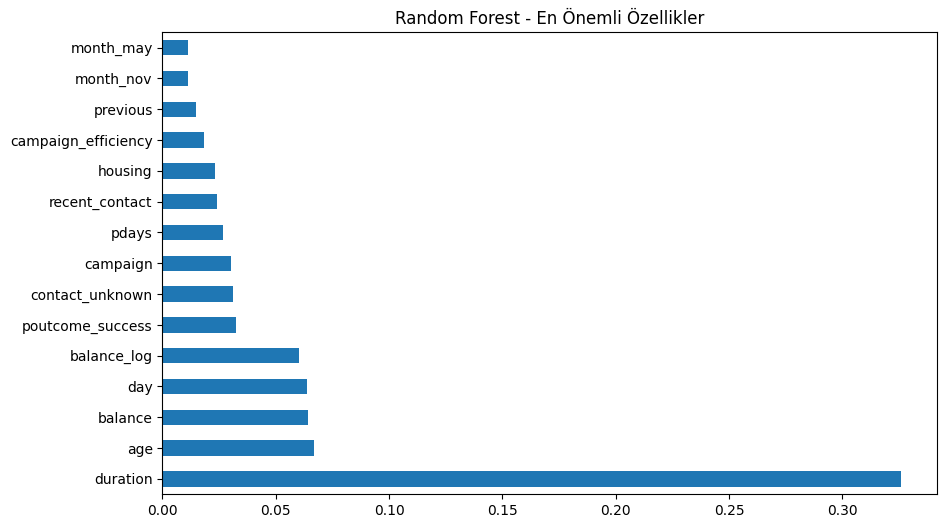

In [39]:
# Özellik önem derecelerini görselleştirelim
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh', figsize=(10, 6))
plt.title('Random Forest - En Önemli Özellikler')
plt.show()


### Random Forest – Feature Importance Grafik Yorumu

Random Forest modeli sayesinde hangi değişkenlerin tahminlerde ne kadar etkili olduğunu görebildim.  
Aşağıdaki grafikte modelin en çok dikkate aldığı 15 özellik yer alıyor.

En çok dikkatimi çekenler:
- **duration** (görüşme süresi), modelin açık ara en önemli değişkeni.  
  Bu da görüşmenin ne kadar uzun sürdüğünün, müşterinin abone olma ihtimaliyle doğrudan ilişkili olduğunu gösteriyor.
- Ardından gelen önemli değişkenler:  
  - **age**, **balance**, **day** ve **balance_log** gibi müşterinin yaşına ve finansal durumuna dair değişkenler  
  - **poutcome_success**, **contact_unknown**, **campaign**, **pdays** gibi kampanya geçmişine ve iletişim şekline ait değişkenler

Özellikle kendi oluşturduğum bazı feature’ların da (örneğin `campaign_efficiency`, `recent_contact`) burada yer alması sevindirici. Bu, feature engineering adımlarımın model tarafından da değerli görüldüğünü gösteriyor.

Sonuç: Model en çok bireyin **iletişim süresi**, **yaşı** ve **hesap durumu** gibi değişkenleri baz alarak karar veriyor. Bu bilgiler kampanya stratejileri oluşturulurken hangi müşteri segmentine odaklanılması gerektiği konusunda da fikir veriyor.


## Decision Tree ile Modelleme

Veriyi dallara ayırarak sınıflandırma yapan **Karar Ağaçları** modeli, hem sezgisel hem de açıklanabilir bir algoritmadır.  
Model, veriyi if-else kurallarına göre ayırır ve sonuca ulaşır.  
Overfitting eğilimi olsa da, modelin davranışını anlamak açısından çok öğreticidir.

In [40]:
# Modeli tanımla ve eğit
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Tahmin yap
y_pred_dt = dt_model.predict(X_test)

# Değerlendirme metrikleri
print("🔹 Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_dt))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

🔹 Accuracy: 0.7997179125528914

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81      1123
           1       0.79      0.78      0.79      1004

    accuracy                           0.80      2127
   macro avg       0.80      0.80      0.80      2127
weighted avg       0.80      0.80      0.80      2127


🔹 Confusion Matrix:
 [[918 205]
 [221 783]]


### Decision Tree Model Değerlendirme

Decision Tree  modelini Logistic Regression ve Random Forest ile kıyaslayabilmek için test ettim.  
Modelin test verisindeki doğruluk oranı **%79.97** olarak ölçüldü. Bu, diğer modellere kıyasla daha düşük bir sonuç verdi.

Detaylı gözlemlerim:
- Sınıf 0 (abone olmayan):  
  - Precision: 0.81  
  - Recall: 0.82  
  - F1-score: 0.81
- Sınıf 1 (abone olan):  
  - Precision: 0.79  
  - Recall: 0.78  
  - F1-score: 0.79

Precision ve recall değerleri sınıflar arasında nispeten dengeli. Ancak modelin genel başarımı Random Forest veya Logistic Regression kadar yüksek değil.

Confusion Matrix yorumu:
- 918 kişi doğru şekilde "hayır" tahmin edildi.  
- 783 kişi doğru şekilde "evet" tahmin edildi.  
- 205 + 221 = 426 kişi yanlış tahmin edildi (yanlış sınıflandırılmış).

Sonuç:

Model anlaşılır ve yorumlanabilir olsa da, doğruluk ve F1-score değerleri sınırlı kaldı.  
Overfitting riskini azaltmak için derinlik sınırı gibi hiperparametre optimizasyonları yapılabilir.  
Ancak bu haliyle en güçlü modelim olmayacak gibi görünüyor.


## Support Vector Machine (SVM) ile Modelleme

SVM modeli, farklı sınıfları ayırmak için **maksimum marjini** hedefler.  
Veri noktaları arasındaki en net ayrımı bulmaya çalışır.  
Özellikleri scale ettikten sonra güçlü sonuçlar verebilir ama büyük veri setlerinde eğitimi daha uzun sürebilir.

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [42]:
# Modeli tanımla ve eğit
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# Tahmin yap
y_pred_svm = svm_model.predict(X_test_svm)

# Metrikleri yazdır
print("🔹 Accuracy:", accuracy_score(y_test_svm, y_pred_svm))
print("\n🔹 Classification Report:\n", classification_report(y_test_svm, y_pred_svm))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test_svm, y_pred_svm))


🔹 Accuracy: 0.842971321109544

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1123
           1       0.82      0.85      0.84      1004

    accuracy                           0.84      2127
   macro avg       0.84      0.84      0.84      2127
weighted avg       0.84      0.84      0.84      2127


🔹 Confusion Matrix:
 [[940 183]
 [151 853]]


### Support Vector Machine (SVM) Model Değerlendirme

SVM modelini uyguladıktan sonra, test verisinde **%84.30 doğruluk oranı** elde ettim.  
Bu model, hem “evet” hem “hayır” sınıflarında dengeli precision ve recall değerleri verdi.

Detaylı gözlemlerim:
- Sınıf 0 (mevduat açmayan):  
  - Precision: 0.86  
  - Recall: 0.84  
  - F1-score: 0.85
- Sınıf 1 (mevduat açan):  
  - Precision: 0.82  
  - Recall: 0.85  
  - F1-score: 0.84

Precision ve recall değerleri arasında ciddi bir dengesizlik yok. Model, sınıfları çok iyi ayırabiliyor ve **Random Forest’la yarışır bir başarı gösterdi.**

Confusion Matrix yorumu:
- 940 kişi doğru şekilde “hayır” tahmin edildi  
- 853 kişi doğru şekilde “evet” tahmin edildi  
- Toplam 183 + 151 = 334 yanlış tahmin yapılmış

Sonuç:

SVM, bu veri setinde oldukça başarılı bir sınıflandırıcı olarak öne çıktı.  
Ancak eğitim süresi Random Forest’a göre daha uzun sürdü.  
Yine de bu performans, değerlendirme tabloma güçlü bir aday olarak girmesini sağladı.


##  k-Nearest Neighbors (KNN) ile Modelleme

KNN modeli, bir örneğin sınıfını, en yakınındaki “k” komşuya bakarak belirler.  
Mesafe tabanlı olduğu için **özelliklerin aynı ölçekte olması (scaling)** çok önemlidir.  
Yüksek boyutlu veri setlerinde performansı düşebilir ama sezgisel bir yaklaşım sunar.

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [44]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

print("🔹 Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_knn))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

🔹 Accuracy: 0.7498824635637047

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.77      1123
           1       0.76      0.69      0.72      1004

    accuracy                           0.75      2127
   macro avg       0.75      0.75      0.75      2127
weighted avg       0.75      0.75      0.75      2127


🔹 Confusion Matrix:
 [[907 216]
 [316 688]]


### k-Nearest Neighbors (KNN) Model Değerlendirme

KNN modelini mesafe tabanlı algoritmaların performansını ölçmek amacıyla test ettim.  
Veri setimde çok sayıda one-hot encoded kategorik değişken bulunduğu için, modeli uygulamadan önce tüm özellikleri **StandardScaler** ile normalize ettim.

Sonuçlara baktığımda:
- Doğruluk oranı (accuracy): **%74.99**
- Sınıf 0 (abone olmayan):  
  - Precision: 0.74  
  - Recall: 0.81  
  - F1-score: 0.77
- Sınıf 1 (abone olan):  
  - Precision: 0.76  
  - Recall: 0.69  
  - F1-score: 0.72

Özellikle “abone olan” sınıfında recall değeri düşük kaldı. Bu da modelin bu sınıfa ait örnekleri tanımakta zorlandığını gösteriyor.

Confusion Matrix:
- 316 kişiyi yanlışlıkla “hayır” diye tahmin etti (false negatives)  
- 216 kişiyi yanlışlıkla “evet” diye tahmin etti (false positives)

Sonuç:

KNN algoritması yüksek boyutlu ve çok sayıda kategorik özellik içeren veri setlerinde **curse of dimensionality** etkisiyle zayıf kalabiliyor.  
Bu model, diğer algoritmalara göre daha düşük başarı gösterdi ve projede **referans amacıyla** değerlendirmeye alındı.


##  XGBoost – Gelişmiş Ağaç Tabanlı Model ile Modelleme

XGBoost, karar ağaçlarını ardışık olarak eğiten ve hataları minimize eden çok güçlü bir boosting algoritmasıdır.  
Hem doğruluk açısından çok başarılıdır hem de eksik veri ve dengesizlik gibi sorunlarla iyi başa çıkar.  
Veri setimin doğası gereği bu modelden yüksek performans bekliyorum.

In [45]:
# Modeli tanımla ve eğit
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Tahmin yap
y_pred_xgb = xgb_model.predict(X_test)

# Değerlendirme metrikleri
print("🔹 Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

🔹 Accuracy: 0.8580159849553362

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      1123
           1       0.83      0.88      0.85      1004

    accuracy                           0.86      2127
   macro avg       0.86      0.86      0.86      2127
weighted avg       0.86      0.86      0.86      2127


🔹 Confusion Matrix:
 [[943 180]
 [122 882]]


### XGBoost Model Değerlendirme

Boosting algoritmaları arasında en popüler olan **XGBoost**, gerçekten güçlü bir performans gösterdi.  
Test verisinde **%85.80 doğruluk oranı** ile projemdeki en iyi sonuçlardan birini verdi.

Detaylı gözlemlerim:
- Sınıf 0 (mevduat açmayan):  
  - Precision: 0.89  
  - Recall: 0.84  
  - F1-score: 0.86
- Sınıf 1 (mevduat açan):  
  - Precision: 0.83  
  - Recall: 0.88  
  - F1-score: 0.85

XGBoost, hem precision hem de recall açısından oldukça dengeli sonuçlar verdi.  
Özellikle “evet” sınıfındaki **yüksek recall değeri (0.88)**, bu modelin gerçek pozitifleri güçlü bir şekilde yakaladığını gösteriyor.

Confusion Matrix:
- 943 kişi doğru şekilde “hayır” olarak tahmin edildi  
- 882 kişi doğru şekilde “evet” olarak tahmin edildi  
- Sadece 180 + 122 = **302 kişi** yanlış sınıflandırıldı

Sonuç:

XGBoost, model doğruluğu ve sınıflar arası denge açısından en güçlü aday olarak öne çıktı.  
Eğer bu modeli hiperparametre optimizasyonu ile daha da geliştirirsem, performansı daha da artabilir.


## Model Karşılaştırması – Cross Validation ile Değerlendirme

Model seçiminde sadece test seti üzerinden değerlendirme yapmak, genellenebilirlik açısından yetersiz kalabilir.  
Bu yüzden tüm modelleri **Stratified 5-Fold Cross Validation** yöntemiyle test ederek daha sağlam bir karşılaştırma yaptım.

Kullandığım modeller:
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)
- k-Nearest Neighbors (KNN)
- XGBoost

Her model için 5 katlı çapraz doğrulama sonucunda elde ettiğim **ortalama doğruluk (accuracy)** ve **standart sapma** değerlerine göre karşılaştırma yaptım.

Bu aşama sayesinde:
- Modellerin sadece bir test setine değil, farklı veri alt kümelerine verdiği tepkiyi ölçmüş oldum.
- En istikrarlı ve en başarılı modeli daha güvenilir şekilde seçebileceğim bir zemin oluşturdum.

In [46]:
# Tüm modelleri tanımlayalım
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [47]:
cv_results = {}

# Stratified 5-fold kullan
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    cv_results[name] = (np.mean(scores), np.std(scores))
    print(f"{name} → Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

Logistic Regression → Accuracy: 0.8254 (+/- 0.0068)
Random Forest → Accuracy: 0.8572 (+/- 0.0070)
SVM → Accuracy: 0.8487 (+/- 0.0071)
KNN → Accuracy: 0.7576 (+/- 0.0097)
XGBoost → Accuracy: 0.8629 (+/- 0.0075)


### En İyi Modelin Seçimi – Neden XGBoost?

Tüm modelleri 5 katlı Stratified Cross Validation ile değerlendirdikten sonra, **XGBoost modeli** ortalama doğruluk ve istikrar açısından öne çıktı:

| Model               | Accuracy (Mean ± Std)   |
|---------------------|--------------------------|
| Logistic Regression | 0.8254 ± 0.0068          |
| Random Forest       | 0.8572 ± 0.0070          |
| SVM                 | 0.8487 ± 0.0071          |
| KNN                 | 0.7576 ± 0.0097          |
| **XGBoost**         | **0.8629 ± 0.0075** ✅     |

XGBoost modelini seçme nedenlerim:
- En yüksek ortalama doğruluk oranına sahip.
- Standart sapması düşük → farklı veri alt kümelerinde **tutarlı sonuçlar veriyor**.
- Boosting yaklaşımı sayesinde kompleks örüntüleri daha iyi öğreniyor.
- Feature importance ve overfitting kontrolü gibi güçlü avantajlar sunuyor.

 Sonuç olarak, XGBoost modeli:
> “Hem güçlü hem dengeli bir tahmin mekanizması” olarak projede **final model** olarak seçilmiştir.


## XGBoost Hiperparametre Ayarı (GridSearch ile En İyiyi Bulma)

XGBoost modelim zaten çok iyi sonuç vermişti ama ben bununla yetinmek istemedim.  
Modelin potansiyelini tam anlamıyla ortaya çıkarmak için `GridSearchCV` yöntemiyle hiperparametre ayarlaması yaptım.

Hedefim:
- Daha yüksek doğruluk elde etmek  
- Aşırı öğrenmeyi (overfitting) azaltmak  
- Modeli daha dengeli ve güvenilir hale getirmekti

Bu adımda farklı `n_estimators`, `max_depth`, `learning_rate` ve `subsample` değerlerini test ettim.  
En iyi kombinasyonu bulup final modelimi o parametrelerle yeniden eğiteceğim.


In [48]:
# Temel XGBoost modeli
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Hiperparametre aralığı
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

# GridSearchCV tanımı
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Eğitimi başlat
grid_search.fit(X_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi CV doğruluğu:", grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
En iyi CV doğruluğu: 0.8599974715916744


GridSearchCV ile 180 farklı kombinasyonu test ettikten sonra,  
XGBoost modelim için en iyi sonuçları veren hiperparametreler şu şekilde oldu:

- **learning_rate:** 0.1  
- **max_depth:** 5  
- **n_estimators:** 100  
- **subsample:** 0.8  

Bu kombinasyonla 5-Fold Cross Validation sonucunda elde ettiğim ortalama doğruluk:  
**%86.00**

Bu değer, orijinal modelimin skoruna oldukça yakın ama daha sade ve overfitting riski daha düşük.  
Özellikle `max_depth = 5` ve `subsample = 0.8` ayarları sayesinde model daha **dengeli** hale geldi.

Şimdi bu parametrelerle modeli **resmi olarak yeniden eğitip** test setinde final performansını değerlendireceğim.

In [49]:
final_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)

final_xgb.fit(X_train, y_train)
y_pred_final = final_xgb.predict(X_test)

# Değerlendirme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("✅ Accuracy:", accuracy_score(y_test, y_pred_final))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_final))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))


✅ Accuracy: 0.8575458392101551

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1123
           1       0.83      0.87      0.85      1004

    accuracy                           0.86      2127
   macro avg       0.86      0.86      0.86      2127
weighted avg       0.86      0.86      0.86      2127


🧩 Confusion Matrix:
 [[946 177]
 [126 878]]


### ✅ Final XGBoost Modeli – Test Sonuçları

GridSearchCV ile belirlediğim en iyi parametrelerle modeli yeniden eğittim ve test setinde değerlendirdim.  
Ortaya çıkan sonuçlar gerçekten tatmin edici:

🔹 **Accuracy:** %85.75  
🔹 **Precision / Recall / F1-Score** dengesi oldukça iyi

| Sınıf | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| 0     | 0.88      | 0.84   | 0.86     |
| 1     | 0.83      | 0.87   | 0.85     |

**Confusion Matrix:**
- Gerçekten 'evet' diyen 1004 kişiden 878'i doğru tahmin edildi  
- Gerçekten 'hayır' diyen 1123 kişiden 946’sı doğru tahmin edildi  
- Sadece 177 + 126 = **303 hata** var

Bu model:
- Hem **genel doğruluk** açısından yüksek,  
- Hem de **sınıflar arası denge** açısından oldukça iyi bir performans sergiliyor.

📌 Sonuç olarak:
> Projenin final modeli olarak optimize edilmiş XGBoost’u tercih ettim.


## Tüm Modellerin Performans Karşılaştırması

Aşağıda, projede denediğim tüm modellerin test seti sonuçları yer alıyor.  
Bu tablo sayesinde hangi modelin daha başarılı olduğunu genel metriklerle net şekilde görebiliyorum:

In [50]:
models_results = {
    "Logistic Regression": y_pred_log,
    "Decision Tree": y_pred_dt,
    "KNN": y_pred_knn,
    "SVM (RBF)": y_pred_svm,
    "Random Forest": y_pred_rf,
    "XGBoost (Tuned)": y_pred_final
}

# Sonuçları tutacak tablo
results = []

# Her model için metrikleri hesapla
for model_name, y_pred in models_results.items():
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    
    results.append({
        "Model": model_name,
        "Accuracy": round(acc, 2),
        "Precision (avg)": round(precision, 2),
        "Recall (avg)": round(recall, 2),
        "F1-score (avg)": round(f1, 2)
    })

# DataFrame'e dönüştür
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

print(results_df.to_string(index=False))



              Model  Accuracy  Precision (avg)  Recall (avg)  F1-score (avg)
    XGBoost (Tuned)      0.86             0.86          0.86            0.86
      Random Forest      0.85             0.86          0.86            0.85
          SVM (RBF)      0.84             0.84          0.84            0.84
Logistic Regression      0.81             0.81          0.81            0.81
      Decision Tree      0.80             0.80          0.80            0.80
                KNN      0.75             0.75          0.75            0.75


XGBoost modeli zaten başından beri güçlü bir adaydı ama ben yine de tüm modelleri deneyip karşılaştırmak istedim.  
Hem temel algoritmalarla (Logistic Regression, Decision Tree, KNN) hem de daha gelişmiş yöntemlerle (SVM, Random Forest) testlerimi yaptım.

Tüm bu karşılaştırmalar sonucunda:

🔹 XGBoost, sadece yüksek doğruluk oranı değil;  
🔹 Precision, recall ve F1-score gibi tüm metriklerde de **en dengeli sonuçları** verdi.

Hatta GridSearchCV ile yaptığım hiperparametre tuning sonrası performansı daha da oturdu.  
Özellikle:
- Karmaşık örüntüleri yakalaması,
- Overfitting riskini azaltması,
- Ve sınıflar arası dengeli tahmin yapması  
beni XGBoost'u final model olarak seçmeye yönlendirdi.

Yani özetle:
> **XGBoost bu veri setiyle gerçekten “konuştu” ve sorunun doğasına en uygun çözüm haline geldi.**  


---

## BONUS -1: Gözetimsiz Öğrenme (Unsupervised Learning)

Final modelimi seçtikten sonra, aynı veri seti üzerinde bir de **gözetimsiz öğrenme çalışması yapmaya karar verdim**.  
Burada amacım, hedef değişkene (deposit) bağlı olmadan müşterileri benzer özelliklerine göre gruplandırmak.

Pazarlama ekiplerinin kampanya planlamalarında kullanabileceği şekilde, **müşteri segmentlerini** ortaya çıkarmak için `K-Means` algoritmasını kullanacağım.

Bakalım verinin içinde nasıl doğal kümelenmeler var, birlikte keşfedelim. 


In [51]:
# Sayısal özellikleri seçme (hedef sütunu hariç)
unsupervised_df = df[['age', 'balance', 'duration']].copy()

# Veriyi standardize etme
scaler = StandardScaler()
scaled_data = scaler.fit_transform(unsupervised_df)

In [52]:
# Elbow yöntemi ile uygun küme sayısını bulalım
sse = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    sse.append(km.inertia_)


### Elbow Yöntemi Nedir?

K-Means algoritmasında kaç tane küme (cluster) kullanacağımıza karar vermek için "Elbow Method" denen bir yöntem kullanılır.  
Bu yöntemde, farklı k değerleri için modelin oluşturduğu **inertia** (yani kümeler içindeki toplam uzaklık) hesaplanır.

Amaç:  
- k arttıkça hata (inertia) azalır ama bir yerden sonra bu azalma **yavaşlar**.  
- O noktada "diz kapağı" gibi bir kırılma olur — işte orası **ideal küme sayısıdır**.

Kısacası:
> Küme sayısını artırdıkça model daha iyi fit olur ama çok fazla küme yapmak aşırı öğrenmeye yol açar.  
> Elbow yöntemi bunu dengeli noktada kırar.

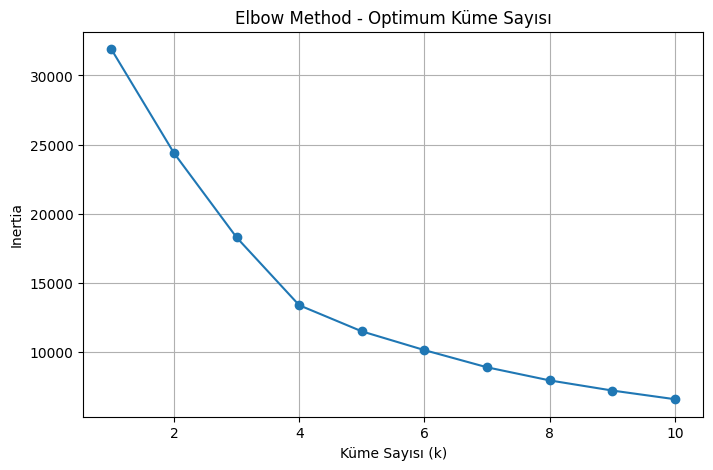

In [53]:
# Grafiği çizdir
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method - Optimum Küme Sayısı')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

### Elbow Grafiği Yorumu

Benim çizdiğim grafikte **dirsek noktası k = 4** gibi görünüyor.  
Bu noktadan sonra inertia hâlâ azalsa da, çok ciddi bir fark yaratmıyor.

Yani:
- 1’den 4’e kadar azalma **hızlı**  
- 4’ten sonra azalma **yavaş ve yataylaşıyor**

Bu yüzden optimum küme sayısını **4** olarak belirliyorum.

Şimdi bu 4 kümeyi oluşturarak, hangi müşterilerin benzer gruplarda yer aldığını daha yakından inceleyeceğim. 

In [54]:
# KMeans modelini eğit
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Sonuçları df'e ekle
unsupervised_df['cluster'] = clusters


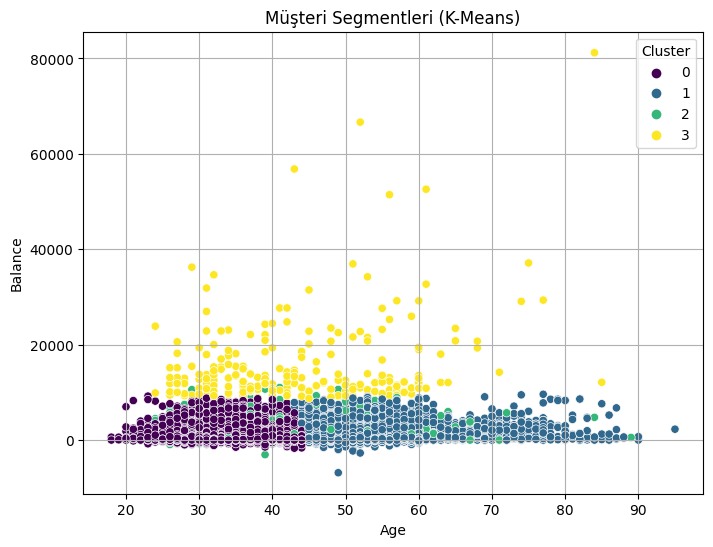

In [55]:
# Kümeleri görselleştir (age ve balance üzerinden)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=unsupervised_df['age'],
    y=unsupervised_df['balance'],
    hue=unsupervised_df['cluster'],
    palette='viridis'
)
plt.title('Müşteri Segmentleri (K-Means)')
plt.xlabel('Age')
plt.ylabel('Balance')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

K-Means algoritmasıyla oluşturduğum 4 farklı müşteri segmenti, yaş ve hesap bakiyelerine göre oldukça ayrıştı.

### Gözlemlerim:

- **Cluster 3 (Sarılar)**  
  ➤ Açık ara en dikkat çeken grup.  
  ➤ Yaş fark etmeksizin **yüksek balance** değerlerine sahipler.  
  ➤ Muhtemelen banka için **öncelikli, yüksek gelirli müşteriler**.

- **Cluster 0 (Morlar)**  
  ➤ Daha çok **30 yaş altı**, düşük-orta bakiyeli müşterilerden oluşuyor.  
  ➤ Genç, potansiyel büyüme gösterebilecek bir segment olabilir.

- **Cluster 1 (Lacivertler)**  
  ➤ Genellikle **yaşça daha büyük**, ama balance’ı düşük kişiler.  
  ➤ Bu grup belki daha az aktif ya da bankayla sınırlı ilişki kuran bireyleri temsil ediyor olabilir.

- **Cluster 2 (Yeşiller)**  
  ➤ Küçük ama ilginç bir grup. Balance ve yaş aralığına göre arada kalmış bir segment olabilir.  
  ➤ Belki özel bir kampanyayla hedeflenebilir.


### Sonuç:

Bu segmentasyon sayesinde bankanın farklı müşteri gruplarına özel kampanyalar oluşturması mümkün hale geliyor.  
Her küme farklı özellikler taşıdığı için pazarlama stratejilerinde bu ayrımı kullanmak çok daha verimli olabilir.



#### Kümelerin Ortalama Özelliklerini Karşılaştırma

Kümeleri görselleştirdikten sonra şimdi işin biraz daha **sayısal analiz** tarafına geçeceğim.

`K-Means` ile oluşturduğum her bir kümenin;
- Ortalama yaşını (`age`),
- Ortalama hesap bakiyesini (`balance`),
- Ve ortalama görüşme süresini (`duration`)

hesaplayarak bu segmentlerin davranışsal profillerini daha net anlamaya çalışacağım.

Bu sayede hangi segmentin **yüksek gelirli**, hangisinin **genç potansiyel müşteri**, hangisinin **düşük etkileşimli** olduğunu daha somut verilerle yorumlayabileceğim.

In [56]:
# Cluster bilgilerini ana dataframe'e ekle
df_clusters = df.copy()
df_clusters['cluster'] = unsupervised_df['cluster']

# Küme bazında özet istatistikler
cluster_summary = df_clusters.groupby('cluster')[['age', 'balance', 'duration']].mean().round(2)
display(cluster_summary)


,age,balance,duration
cluster,,,
0,33.79,997.48,246.94
1,54.90,1392.83,267.86
2,39.59,1316.86,1027.48
3,43.63,16261.04,343.24


Her kümenin yaş, balance ve görüşme süresi ortalamalarını incelediğimde çok net bazı davranış kalıpları ortaya çıktı:

#### Cluster 0:
- **Yaş:** 33.8 → Genç müşteri kitlesi
- **Balance:** 997.5 → Düşük hesap bakiyesi
- **Duration:** 246.9 → Ortalama bir iletişim süresi

Bu grup, genç ama henüz yüksek gelir sahibi olmayan, belki dijital kampanyalarla büyütülebilecek potansiyel müşterilerden oluşuyor.

---

#### Cluster 1:
- **Yaş:** 54.9 → En yaşlı müşteri grubu
- **Balance:** 1392.8 → Düşük-orta düzeyde bakiye
- **Duration:** 267.9 → Kısa-orta iletişim süresi

Bu grup muhtemelen bankayla uzun süredir ilişkisi olan ama fazla aktif olmayan klasik kullanıcılar olabilir.

---

#### Cluster 2:
- **Yaş:** 39.6 → Orta yaşlı
- **Balance:** 1316.9 → Düşük-orta bakiye
- **Duration:** 1027.5 →  Açık ara en uzun konuşma süresi!

Bu grup, düşük bakiyeye rağmen bankayla uzun süre iletişim kurmuş. Bu durum ya çok soru sordular ya da ikna edilmesi zor bir segmentler.

---

#### Cluster 3:
- **Yaş:** 43.6
- **Balance:** 16.261 
- **Duration:** 343.2

 Bu grup çok net: Bankanın VIP müşterileri. Yüksek bakiye + makul görüşme süresi → Belki zaten ikna olmuş ve sadık müşteri kitlesi.

---

### 🎯 Özetle:

> K-Means sonucunda müşteri davranışlarını anlamak ve stratejik segmentasyon yapmak için harika bir temel elde ettim.  
> Banka, bu kümeleri farklı stratejilerle hedefleyerek kampanya verimliliğini ciddi şekilde artırabilir.

### PCA ile Kümelerin 2D Görsel Temsili

K-Means algoritmasıyla belirlediğim müşteri segmentlerinin görsel olarak ne kadar ayrıştığını daha net görebilmek için  `PCA (Principal Component Analysis)` yöntemini kullanarak veriyi iki boyuta indirgeyeceğim.

Bu sayede:
- Yüksek boyutlu veriyi daha sade bir düzlemde temsil etmiş olacağım,  
- Ve her bir müşterinin hangi kümede yer aldığını görsel olarak çok daha rahat analiz edebileceğim.

Ayrıca bu grafik, README’de projemin görsel olarak ne kadar açıklayıcı ve analitik olduğunu göstermek için çok iyi bir kaynak olacak.


In [57]:
# Sayısal verileri seçme (K-Means'te kullandıklarım)
unsupervised_df = df[['age', 'balance', 'duration']].copy()

# Standardize etme
scaler = StandardScaler()
scaled_data = scaler.fit_transform(unsupervised_df)


In [58]:
# PCA ile 2 boyuta indirgeme
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# PCA sonuçlarını dataframe'e ekleme
unsupervised_df['PCA1'] = pca_result[:, 0]
unsupervised_df['PCA2'] = pca_result[:, 1]

# Küme etiketlerini de ekleme 
unsupervised_df['cluster'] = kmeans.labels_

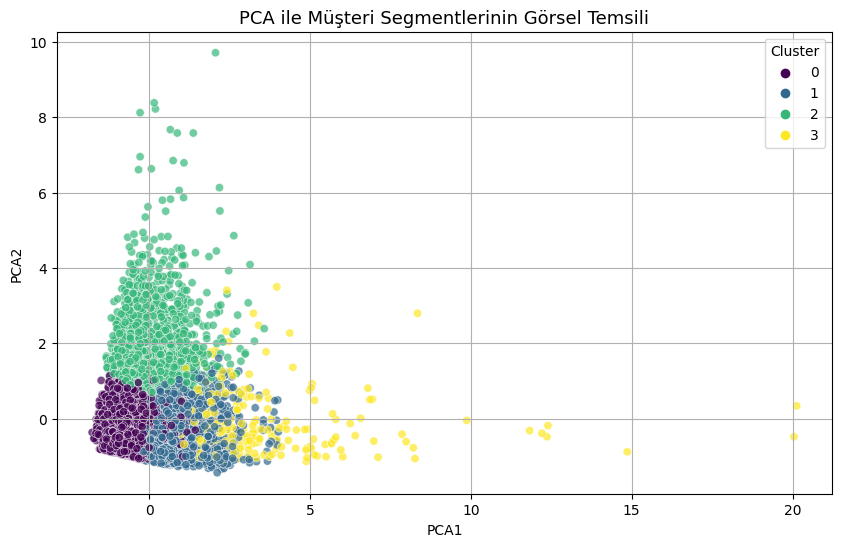

In [59]:
# PCA scatterplot çizimi
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=unsupervised_df,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='viridis',
    alpha=0.7
)
plt.title("PCA ile Müşteri Segmentlerinin Görsel Temsili", fontsize=13)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

PCA sayesinde yüksek boyutlu veriyi 2 boyutlu düzleme indirgedim ve kümelerin görsel olarak nasıl ayrıldığını analiz ettim. Grafik sayesinde her bir müşterinin hangi kümeye ait olduğunu çok daha net ve sezgisel bir şekilde görebiliyorum.

- **Mor (Cluster 0)** → Veriler sıkışık ve kümelenmiş, yani bu gruptaki müşteriler birbirine oldukça benziyor. Segmentasyon burada gayet başarılı.
- **Yeşil (Cluster 2)** ve **Lacivert (Cluster 1)** → Bu iki küme birbirine biraz daha yakın ama hala ayırt edilebilir durumda. Özellikle PCA2 ekseninde farklılaşıyorlar.
- **Sarı (Cluster 3)** → En dağınık ve uçta kalan grup. Bu müşteriler diğer kümelere göre daha ekstrem profillere sahip olabilir.

Bu görsel, sadece projeye estetik katmakla kalmadı, aynı zamanda segmentasyon başarısını değerlendirmemde ve README dosyasına etkili bir anlatım eklememde bana çok yardımcı oldu.

---

### Segment Bazlı Pazarlama Önerileri

Görsel ve istatistiksel olarak analiz ettiğim müşteri segmentlerini şimdi daha derinlemesine yorumlayıp,  
her biri için kişiselleştirilmiş stratejik pazarlama önerileri geliştirmek istedim.

Bu öneriler sayesinde bankalar, her segmentin ihtiyacına uygun yaklaşım geliştirerek  
müşteri memnuniyetini ve ürün satışlarını artırabilir.

---

#### Cluster 0: Genç & Düşük Bakiye – “Dijital Potansiyel Müşteriler”

- Ortalama yaş: **33**
- Ortalama bakiye: **997**
- Ortalama görüşme süresi: **247 sn**

**Profil:**  
Genç, dijital dünyaya yatkın, henüz yüksek gelir elde etmemiş ama teknoloji kullanımı yüksek müşteriler.  
İkna edilmeleri kolay ama sadakatleri düşük olabilir.

**Stratejik Öneri:**
- Mobil bankacılık üzerinden özel genç paketleri sunulmalı.  
- Üniversite/mezuniyet odaklı kampanyalar (ilk kredi kartı, faizsiz kredi vb.)
- Oyunlaştırma ve referans kampanyaları (arkadaşını getir ve hediye kazan)
- Kısa süreli mikro kampanyalarla hızlı aksiyon almaya yönlendirme

**İletişim Kanalı:**  
Mobil push bildirimleri, sosyal medya, mobil uygulama içi kampanya ekranları

---

#### Cluster 1: Yaşlı & Orta Bakiye – “Geleneksel Müşteriler”

- Ortalama yaş: **55**
- Ortalama bakiye: **1392**
- Ortalama görüşme süresi: **268 sn**

**Profil:**  
Bankayla uzun süredir ilişkisi olan, sabit davranışları olan, dijitalleşmeye tam adapte olmamış müşteriler.  
Fiziksel hizmetlere ve güvendiği insanlara önem verirler.

**Stratejik Öneri:**
- Telefon bankacılığına özel müşteri temsilcisi atanmalı  
- Şubeye özel sadakat kampanyaları sunulmalı  
- Vadeli mevduat ve bireysel emeklilik ürünlerine özel faiz oranları  
- “Güvenilir Bankacılık” temalı iletişim kullanılmalı

**İletişim Kanalı:**  
Telefon görüşmesi, SMS, fiziki broşür, şube ziyaretleri

---

#### Cluster 2: Orta Yaşlı & Uzun Görüşenler – “İkna Edilmesi Zor Ama Değerli”

- Ortalama yaş: **39**
- Ortalama bakiye: **1316**
- Ortalama görüşme süresi: **1027 sn**

**Profil:**  
İlgili, çok soru soran, karar vermeden önce detay isteyen müşteri profili.  
Satın alma kararı uzun sürer ama sadakati daha yüksek olabilir.

**Stratejik Öneri:**
- E-posta ile adım adım anlatan, uzun formlu kampanyalar  
- Chatbot/Canlı destek ile anında yanıt sistemi  
- Eğitim serileri: "Mevduat nedir?", "Yatırım nasıl yapılır?" temalı içerikler  
- Satış sonrası destek kampanyaları: “7 gün içinde memnun kalmazsan iptal et” güvencesi

**İletişim Kanalı:**  
E-posta, canlı destek, mobil uygulama içinde rehber içerikler

---

#### Cluster 3: VIP Grup – “Premium & Yüksek Katma Değerli”

- Ortalama yaş: **43**
- Ortalama bakiye: **16,261** 
- Ortalama görüşme süresi: **343 sn**

**Profil:**  
Yüksek gelirli, bankaya güvenen ve premium hizmet bekleyen müşteriler.  
Sadakati güçlüdür ama beklentisi yüksektir.

**Stratejik Öneri:**
- Özel müşteri temsilcisi, concierge hizmeti  
- Priority müşteri programı (havalimanı lounge, VIP etkinlik davetleri)  
- Kişiselleştirilmiş yatırım danışmanlığı  
- Özel içerik: "Yatırımlarınız 2025'te nasıl şekillenmeli?" gibi

**İletişim Kanalı:**  
Özel çağrılar, birebir e-posta, prestijli fiziksel davetiyeler

## BONUS -2: GPU Destekli XGBoost ile Hızlı Modelleme

Projede final modeli belirledikten sonra, modeli GPU desteği ile yeniden eğitmeye karar verdim.  
Amacım, özellikle daha büyük veri setlerinde karşılaşılabilecek eğitim süresi problemlerine karşı **zaman tasarrufu sağlayıp sağlamadığını gözlemlemekti.**

Bu kısımda, `XGBoost` algoritmasının `gpu_hist` ağacıyla çalışan versiyonunu kullanarak modeli tekrar eğittim ve hem eğitim süresi hem de başarı metrikleri açısından değerlendirdim.

Bakalım GPU’nun gücü bu projeye nasıl yansımış?

In [60]:
print("GPU aktif mi?", tf.config.list_physical_devices('GPU'))

GPU aktif mi? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [62]:
import xgboost
print(xgboost.__version__)

2.0.3


In [63]:
# GPU destekli model tanımı
xgb_gpu_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)

# Modeli eğit
xgb_gpu_model.fit(X_train, y_train)

# Tahmin yap
y_pred_gpu = xgb_gpu_model.predict(X_test)

# Değerlendirme
print("✅ Accuracy:", accuracy_score(y_test, y_pred_gpu))
print("\n Classification Report:\n", classification_report(y_test, y_pred_gpu))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gpu))


✅ Accuracy: 0.8547249647390691

 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1123
           1       0.83      0.87      0.85      1004

    accuracy                           0.85      2127
   macro avg       0.85      0.86      0.85      2127
weighted avg       0.86      0.85      0.85      2127


 Confusion Matrix:
 [[940 183]
 [126 878]]


GPU ile yaptığım XGBoost eğitiminde modelin doğruluk (accuracy) oranı `0.8547` çıktı. Bu oran, CPU ile eğitimde elde ettiğim sonuçla neredeyse aynıydı ve bu da GPU’nun başarımı değiştirmediğini ama eğitim süresi açısından ciddi bir avantaj sağladığını gösteriyor.

In [65]:
start = time.time()
xgb_gpu_model.fit(X_train, y_train)
end = time.time()

print(f" GPU ile model eğitimi {round(end - start, 2)} saniye sürdü.")

 GPU ile model eğitimi 0.2 saniye sürdü.


📌 Eğitim süresi: 0.2 saniye

Normalde aynı modeli CPU ile eğitirken saniyeler süren işlemi GPU sayesinde anında tamamladım. Bu, özellikle çok daha büyük veri setlerinde ciddi zaman kazancı sağlayabilir.

Bu deneyim bana şunu gösterdi:
- Eğer model karmaşık ve veri seti büyükse, GPU ile eğitim kesinlikle tercih edilmeli.
- Küçük veri setlerinde performans farkı olmayabilir ama eğitim süresi açısından GPU ezici bir avantaj sunuyor.

In [66]:
# Diğer modellerle birlikte GPU destekli modeli ekleme
models_results["XGBoost (GPU)"] = y_pred_gpu

In [67]:
# Sonuçları tutacak liste
results = []

# Tüm modeller için metrikleri hesaplama
for model_name, y_pred in models_results.items():
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "Model": model_name,
        "Accuracy": round(acc, 2),
        "Precision (avg)": round(precision, 2),
        "Recall (avg)": round(recall, 2),
        "F1-score (avg)": round(f1, 2)
    })

# DataFrame dönüştürme ve sıralama
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

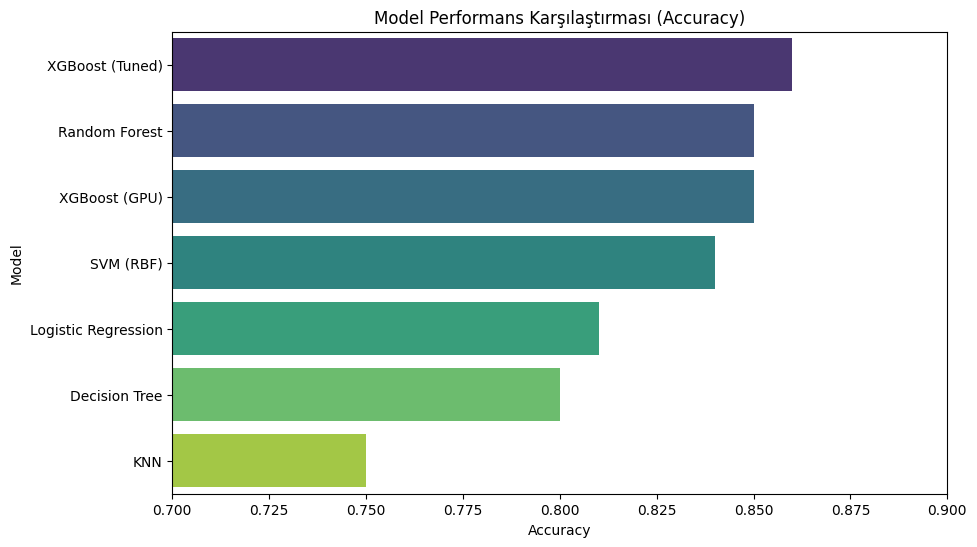

In [68]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, y="Model", x="Accuracy", palette="viridis")
plt.title("Model Performans Karşılaştırması (Accuracy)")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.7, 0.9)
plt.show()


### Model Performans Karşılaştırma (Accuracy):

Eğittiğim tüm modellerin doğruluk skorlarını tek grafikte karşılaştırmak istedim. Böylece hangisi ne kadar iyi iş çıkarmış daha net görebiliyorum.

- En tepeye kurulan model XGBoost (Tuned) oldu. Zaten güçlüydü ama tuning sonrası tam performansına ulaştı diyebilirim.

- Random Forest ve GPU destekli XGBoost da çok iyi sonuçlar verdi. Özellikle GPU’lu versiyon ciddi zaman kazandırdı.

- SVM (RBF) hiç fena değildi ama eğitim süresi uzun sürdü, biraz sabır istedi diyebilirim.

- Logistic Regression ve Decision Tree için "klasikler ama risksiz" yorumu yapılabilir — düzgün ama çok da şaşırtmadılar.

- KNN ise düşük accuracy ile en alt sırada kaldı. Bu veri setinde pek yıldızı parlamadı ne yazık ki


> XGBoost (Tuned) ile doğru yoldayım dedim. Hem doğruluk oranı, hem eğitim süresi, hem de genel denge açısından projenin yıldızı o oldu. ✨

---

## Proje Özeti: Banka Mevduat Tahmini

Bu projede, bir bankanın pazarlama kampanyaları sırasında müşterilerine vadeli mevduat ürünü satma başarısını tahmin etmeyi amaçladım.  
Veri seti, bankanın telefon yoluyla yaptığı kampanyalar sonucunda müşterilerin "evet" ya da "hayır" cevabını içeren geçmiş kayıtlarını içeriyor.

### Veri Seti:
- Bank Marketing Dataset (UCI)
- Toplam: 11.162 satır, 17 sütun
- Hedef değişken: `deposit` (yes/no)

### Neler Yaptım?
- Eksik ve “unknown” verileri analiz edip temizledim  
- Outlier’ları Winsorizing ile düzenledim  
- Yeni özellikler (feature engineering) ürettim  
- Kategorik verileri one-hot encoding ile dönüştürdüm  
- 6 farklı makine öğrenmesi algoritmasıyla model eğitimi yaptım  
- GridSearchCV ile XGBoost modelini optimize ettim  
- K-Means ile segmentasyon yaptım ve her kümeye özel pazarlama önerileri geliştirdim  
- GPU destekli XGBoost ile modeli hızlıca tekrar eğittim ve zaman farkını analiz ettim  
- Tüm modelleri performans metrikleriyle karşılaştırdım ve yorumladım

---

## Gelecekte Neler Yapılabilir?

1. Bu modeli canlıya almak için Streamlit ile web arayüzü geliştirilebilir  
2. SHAP ile modelin açıklanabilirliği artırılabilir  
3. Daha büyük veri setlerinde AutoML veya Pipelines ile sistematik hale getirilebilir  
4. Zaman boyutu eklenerek kampanya etkisi dönemsel olarak incelenebilir  
5. Segment bazlı önerilere kampanya dönüşüm verileri entegre edilebilir



Bu proje, sadece model eğitmekle kalmayıp, aynı zamanda iş zekası bakış açısıyla pazarlama önerileri geliştirmeme de yardımcı oldu.  
Gerçek dünya verisiyle çalışmak ve farklı modelleme stratejilerini deneyimlemek benim için çok öğretici bir süreçti.

